# All the Imports

In [1]:
import sys
import os
import logging
sys.path.insert(1, '../src/')

In [2]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from lassonet import LassoNetClassifier



from RankCorr.picturedRocks import Rocks
import smashpy as smashpy

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *

CPU times: user 7.83 s, sys: 612 ms, total: 8.44 s
Wall time: 7.85 s


In [3]:
logging.getLogger("lightning").setLevel(logging.ERROR)
pl_loggers = [ logging.getLogger(name) for name in logging.root.manager.loggerDict if 'lightning' in name ]

for logger in pl_loggers:
    logger.setLevel(logging.ERROR)
    
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# These should be parameters later on 

In [4]:
z_size = 16
hidden_layer_size = 64

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 25, 50, 100, 250]
num_times = 10
k = 50
gpus = 1
tpu_cores = None
precision = 32

# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
possible_seeds = np.random.randint(low=1, high = 1000000, size = 400)
seed_index = 0

In [5]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

# Here goes all the stuff that we change from dataset to dataset

In [6]:
from os import path

In [7]:
dataset_dir = '../data/CITE-seq/'
model_save_path = '../data/CITE-seq/models/'
viz_save_path = '../data/CITE-seq/visualizations/'

if not path.exists(model_save_path):
  os.makedirs(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.makedirs(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.makedirs(viz_save_path)

  

# Dataset Specific Processing

`

In [8]:
citeseq_adata = sc.read_h5ad(dataset_dir + "CITEseq.h5ad")

In [9]:
citeseq_adata.shape

(8617, 500)

In [10]:
X = citeseq_adata.X.copy()

In [11]:
citeseq_adata.obs['annotation'] = citeseq_adata.obs['names']
labels = citeseq_adata.obs['names'].values
encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

In [12]:
input_size = X.shape[1]

In [13]:
X.shape

(8617, 500)

# Set Up Models

Training here will differ than in other notebooks.

Training multiple times at k = 50

Also training one trial at k's ranging from 10 to 250.

## All Markers

In [14]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    all_markers = np.arange(X.shape[1])
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = all_markers)
    np.save(model_save_path + 'all_markers_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'all_markers_{}.npy'.format(tryy), all_markers)
    np.save(model_save_path + 'experiment_data_folds/all_markers_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'All Marker Visualization', path = viz_save_path + 'all_markers_{}.pdf'.format(tryy), markers = all_markers)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Pr

CPU times: user 8min 32s, sys: 5.76 s, total: 8min 38s
Wall time: 3min 59s


## Train Smash Random Forest





In [14]:
# needed for random forest Smash
!mkdir Figures

mkdir: cannot create directory ‘Figures’: File exists


 * Initialising ...

Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

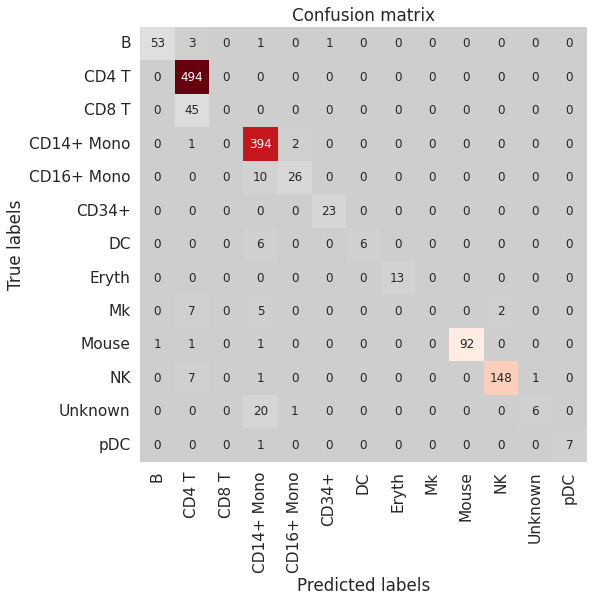

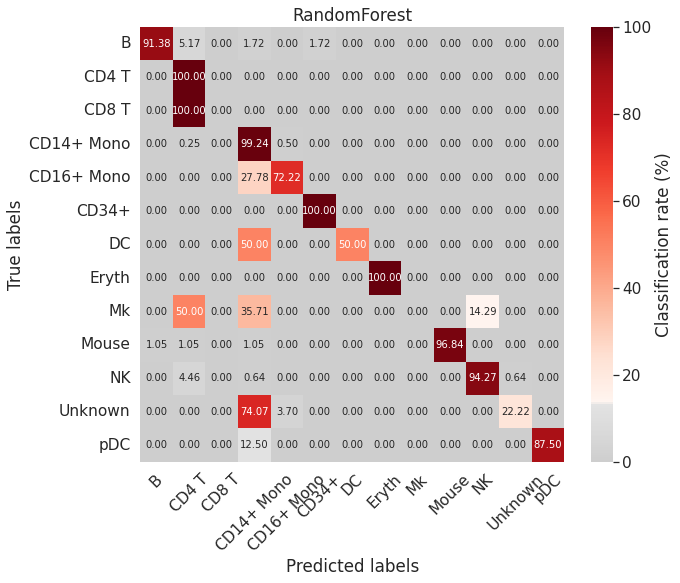

Accuracy: 0.9151559100797679: Misclassification: 0.08484408992023207
              precision    recall  f1-score   support

           B       0.98      0.91      0.95        58
       CD4 T       0.89      1.00      0.94       494
       CD8 T       0.00      0.00      0.00        45
  CD14+ Mono       0.90      0.99      0.94       397
  CD16+ Mono       0.90      0.72      0.80        36
       CD34+       0.96      1.00      0.98        23
          DC       1.00      0.50      0.67        12
       Eryth       1.00      1.00      1.00        13
          Mk       0.00      0.00      0.00        14
       Mouse       1.00      0.97      0.98        95
          NK       0.99      0.94      0.96       157
     Unknown       0.86      0.22      0.35        27
         pDC       1.00      0.88      0.93         8

    accuracy                           0.92      1379
   macro avg       0.80      0.70      0.73      1379
weighted avg       0.88      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

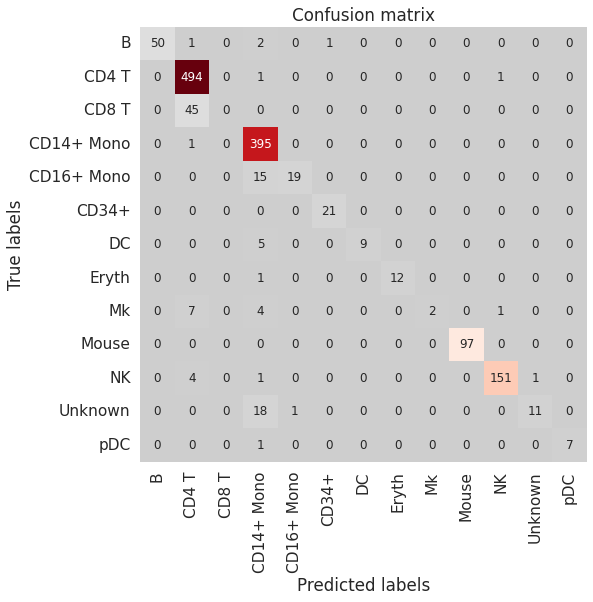

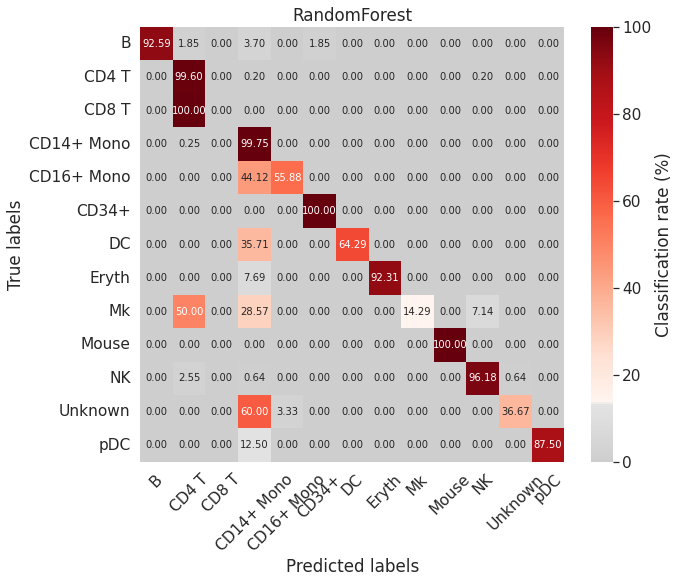

Accuracy: 0.9195068890500363: Misclassification: 0.0804931109499637
              precision    recall  f1-score   support

           B       1.00      0.93      0.96        54
       CD4 T       0.89      1.00      0.94       496
       CD8 T       0.00      0.00      0.00        45
  CD14+ Mono       0.89      1.00      0.94       396
  CD16+ Mono       0.95      0.56      0.70        34
       CD34+       0.95      1.00      0.98        21
          DC       1.00      0.64      0.78        14
       Eryth       1.00      0.92      0.96        13
          Mk       1.00      0.14      0.25        14
       Mouse       1.00      1.00      1.00        97
          NK       0.99      0.96      0.97       157
     Unknown       0.92      0.37      0.52        30
         pDC       1.00      0.88      0.93         8

    accuracy                           0.92      1379
   macro avg       0.89      0.72      0.77      1379
weighted avg       0.89      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

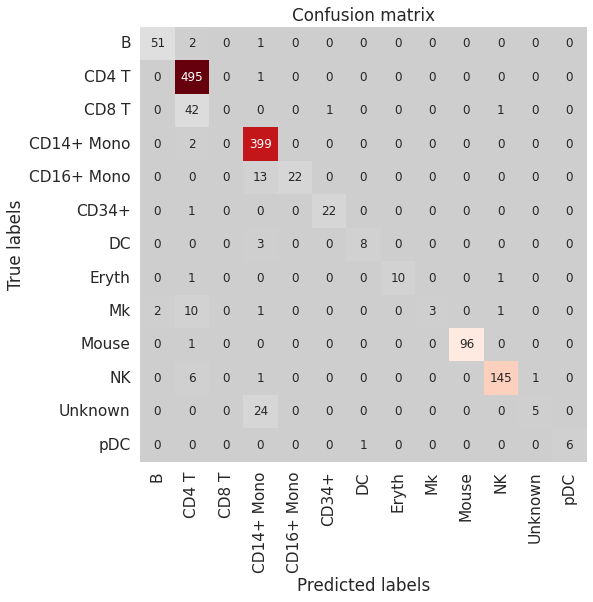

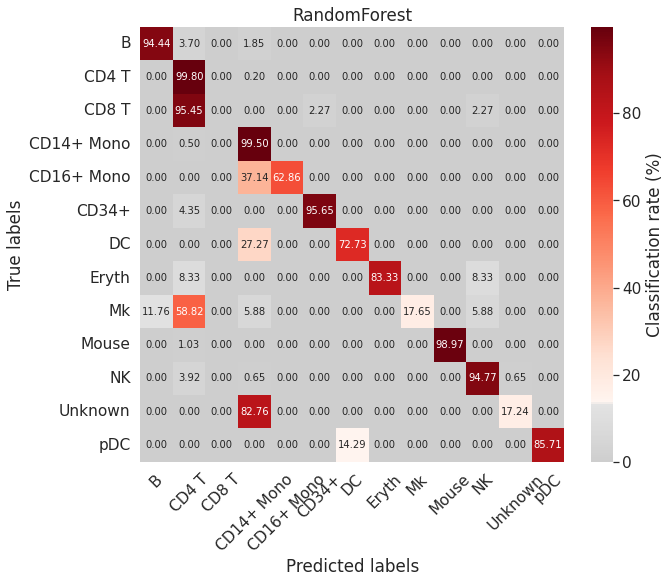

Accuracy: 0.9151559100797679: Misclassification: 0.08484408992023207
              precision    recall  f1-score   support

           B       0.96      0.94      0.95        54
       CD4 T       0.88      1.00      0.94       496
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.90      1.00      0.95       401
  CD16+ Mono       1.00      0.63      0.77        35
       CD34+       0.96      0.96      0.96        23
          DC       0.89      0.73      0.80        11
       Eryth       1.00      0.83      0.91        12
          Mk       1.00      0.18      0.30        17
       Mouse       1.00      0.99      0.99        97
          NK       0.98      0.95      0.96       153
     Unknown       0.83      0.17      0.29        29
         pDC       1.00      0.86      0.92         7

    accuracy                           0.92      1379
   macro avg       0.88      0.71      0.75      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

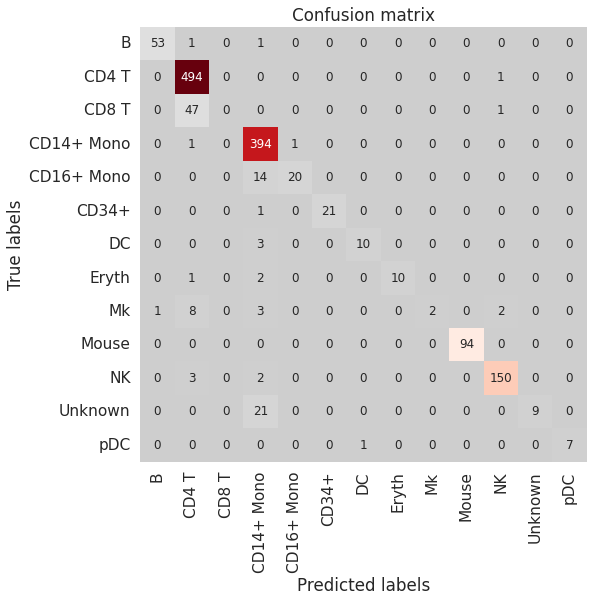

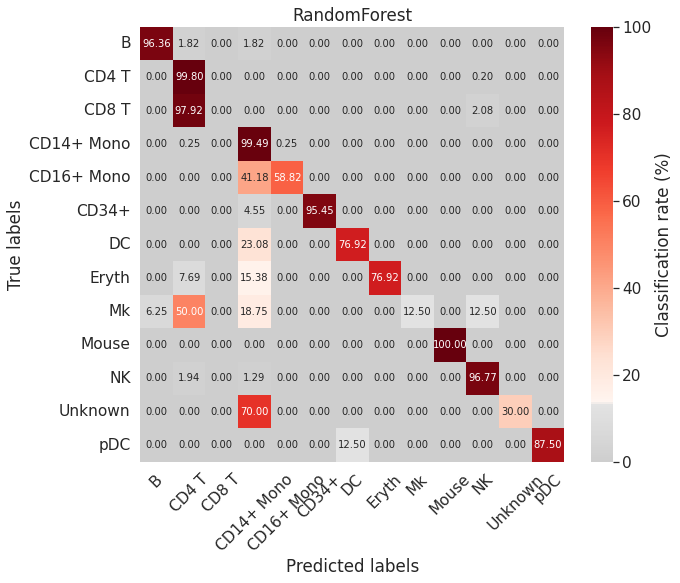

Accuracy: 0.9166062364031907: Misclassification: 0.08339376359680928
              precision    recall  f1-score   support

           B       0.98      0.96      0.97        55
       CD4 T       0.89      1.00      0.94       495
       CD8 T       0.00      0.00      0.00        48
  CD14+ Mono       0.89      0.99      0.94       396
  CD16+ Mono       0.95      0.59      0.73        34
       CD34+       1.00      0.95      0.98        22
          DC       0.91      0.77      0.83        13
       Eryth       1.00      0.77      0.87        13
          Mk       1.00      0.12      0.22        16
       Mouse       1.00      1.00      1.00        94
          NK       0.97      0.97      0.97       155
     Unknown       1.00      0.30      0.46        30
         pDC       1.00      0.88      0.93         8

    accuracy                           0.92      1379
   macro avg       0.89      0.72      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

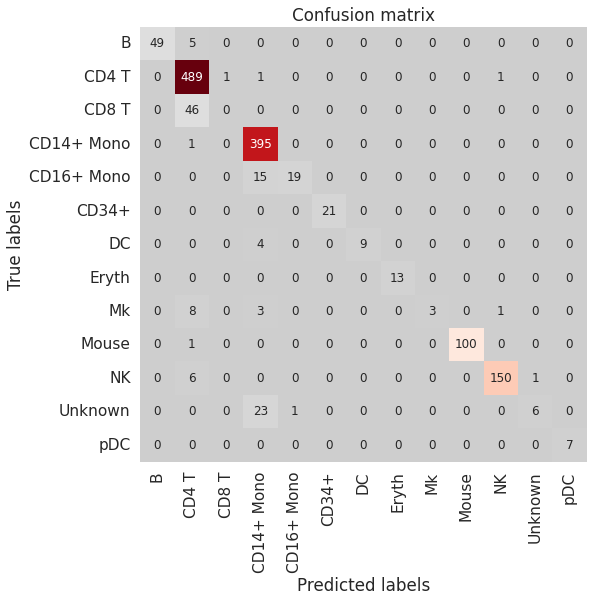

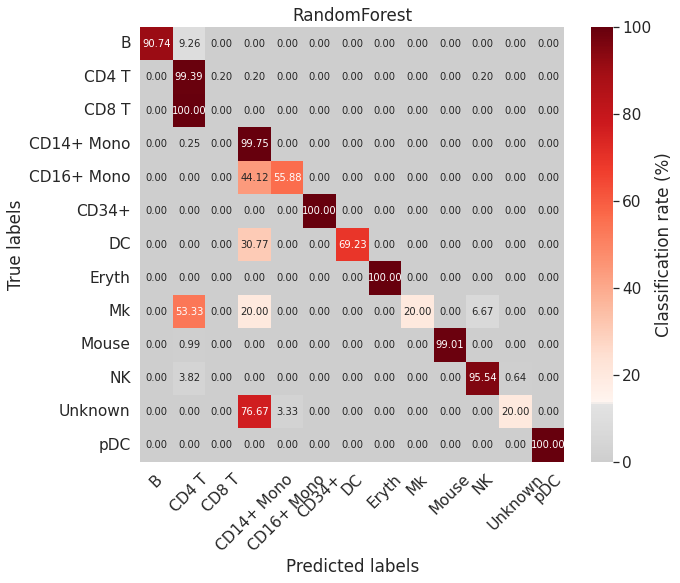

Accuracy: 0.9144307469180566: Misclassification: 0.08556925308194341
              precision    recall  f1-score   support

           B       1.00      0.91      0.95        54
       CD4 T       0.88      0.99      0.93       492
       CD8 T       0.00      0.00      0.00        46
  CD14+ Mono       0.90      1.00      0.94       396
  CD16+ Mono       0.95      0.56      0.70        34
       CD34+       1.00      1.00      1.00        21
          DC       1.00      0.69      0.82        13
       Eryth       1.00      1.00      1.00        13
          Mk       1.00      0.20      0.33        15
       Mouse       1.00      0.99      1.00       101
          NK       0.99      0.96      0.97       157
     Unknown       0.86      0.20      0.32        30
         pDC       1.00      1.00      1.00         7

    accuracy                           0.91      1379
   macro avg       0.89      0.73      0.77      1379
weighted avg       0.89      0.91      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


CPU times: user 4min 47s, sys: 7.1 s, total: 4min 54s
Wall time: 3min 6s


In [15]:
%%time
for k in k_range:
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'smash_rf_markers_k_{}.npy'.format(k), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_k_{}.png'.format(k), markers = smash_markers)

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

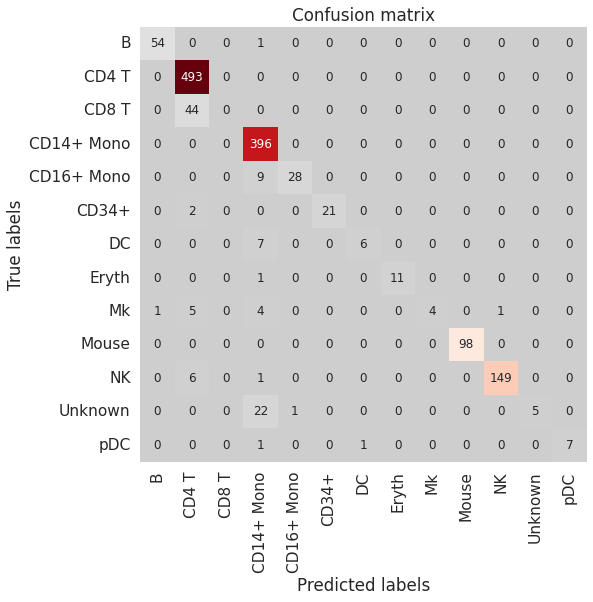

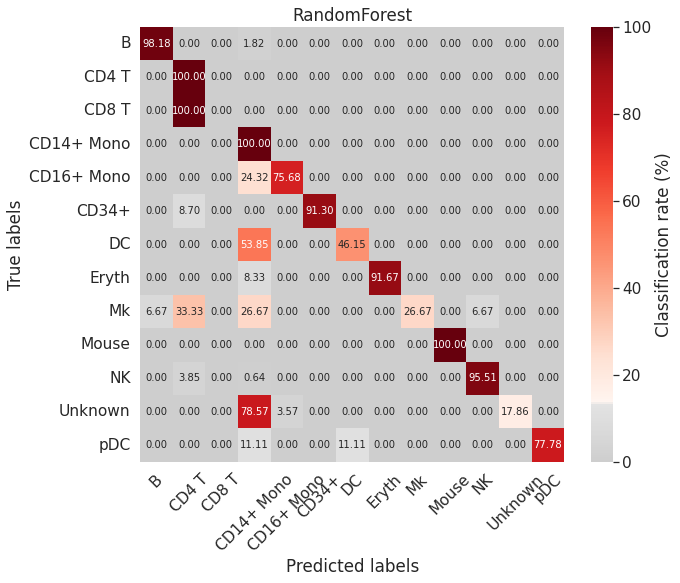

Accuracy: 0.9224075416968818: Misclassification: 0.07759245830311823
              precision    recall  f1-score   support

           B       0.98      0.98      0.98        55
       CD4 T       0.90      1.00      0.95       493
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.90      1.00      0.95       396
  CD16+ Mono       0.97      0.76      0.85        37
       CD34+       1.00      0.91      0.95        23
          DC       0.86      0.46      0.60        13
       Eryth       1.00      0.92      0.96        12
          Mk       1.00      0.27      0.42        15
       Mouse       1.00      1.00      1.00        98
          NK       0.99      0.96      0.97       156
     Unknown       1.00      0.18      0.30        28
         pDC       1.00      0.78      0.88         9

    accuracy                           0.92      1379
   macro avg       0.89      0.71      0.75      1379
weighted avg       0.90      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

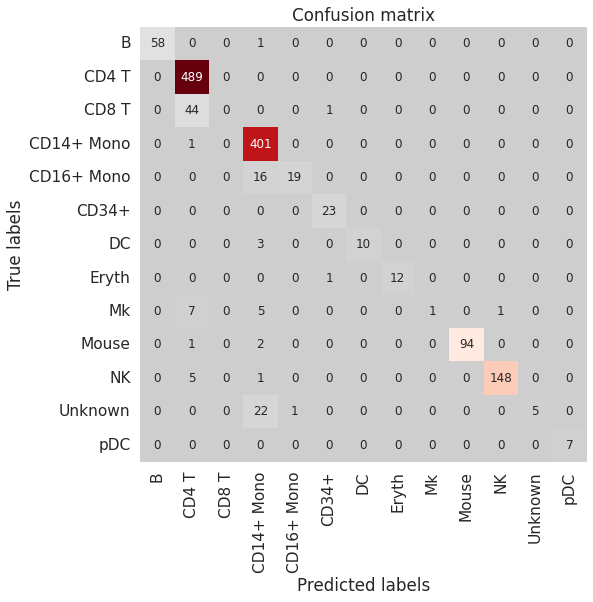

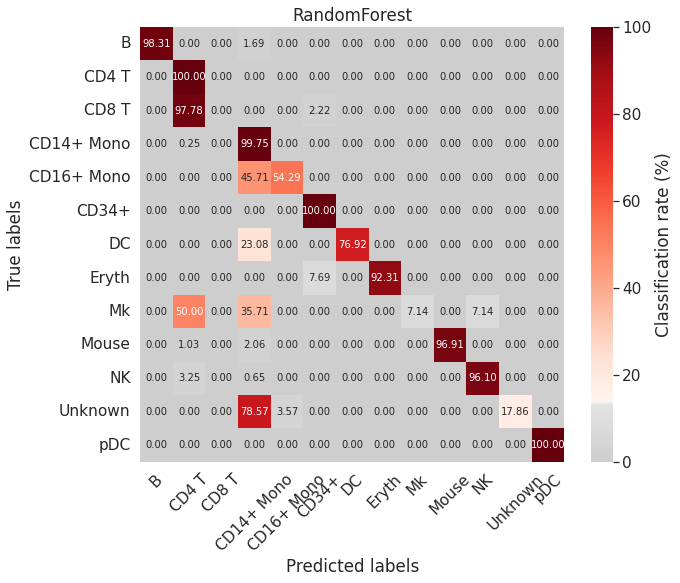

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        59
       CD4 T       0.89      1.00      0.94       489
       CD8 T       0.00      0.00      0.00        45
  CD14+ Mono       0.89      1.00      0.94       402
  CD16+ Mono       0.95      0.54      0.69        35
       CD34+       0.92      1.00      0.96        23
          DC       1.00      0.77      0.87        13
       Eryth       1.00      0.92      0.96        13
          Mk       1.00      0.07      0.13        14
       Mouse       1.00      0.97      0.98        97
          NK       0.99      0.96      0.98       154
     Unknown       1.00      0.18      0.30        28
         pDC       1.00      1.00      1.00         7

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.75      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

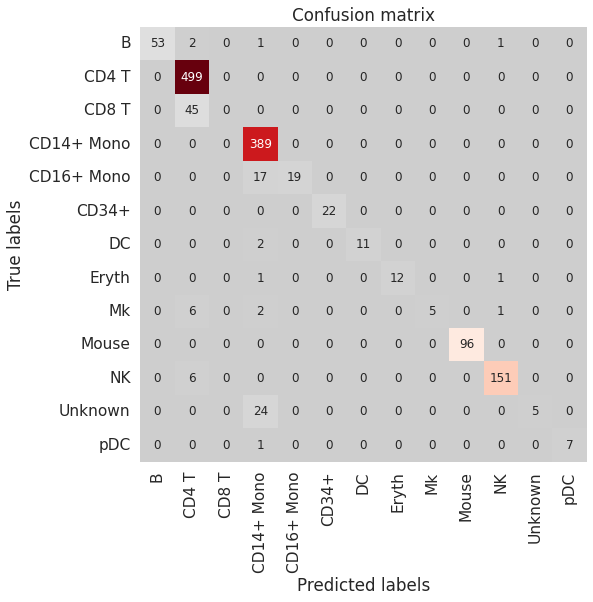

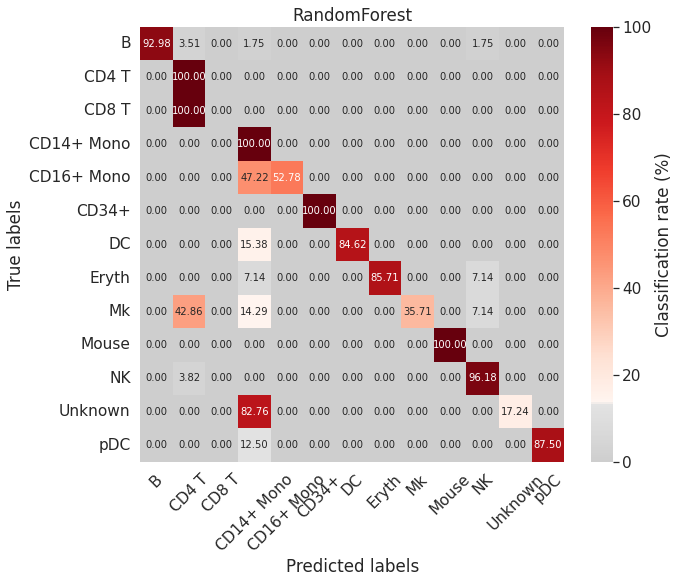

Accuracy: 0.9202320522117476: Misclassification: 0.07976794778825236
              precision    recall  f1-score   support

           B       1.00      0.93      0.96        57
       CD4 T       0.89      1.00      0.94       499
       CD8 T       0.00      0.00      0.00        45
  CD14+ Mono       0.89      1.00      0.94       389
  CD16+ Mono       1.00      0.53      0.69        36
       CD34+       1.00      1.00      1.00        22
          DC       1.00      0.85      0.92        13
       Eryth       1.00      0.86      0.92        14
          Mk       1.00      0.36      0.53        14
       Mouse       1.00      1.00      1.00        96
          NK       0.98      0.96      0.97       157
     Unknown       1.00      0.17      0.29        29
         pDC       1.00      0.88      0.93         8

    accuracy                           0.92      1379
   macro avg       0.90      0.73      0.78      1379
weighted avg       0.90      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

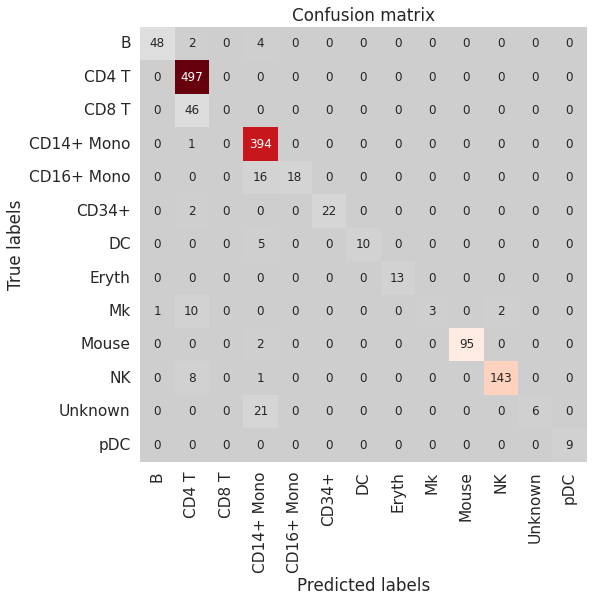

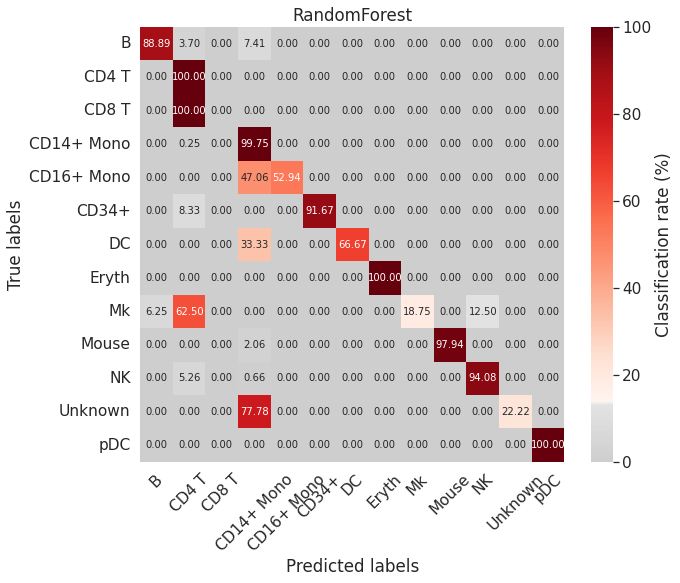

Accuracy: 0.9122552574329225: Misclassification: 0.08774474256707754
              precision    recall  f1-score   support

           B       0.98      0.89      0.93        54
       CD4 T       0.88      1.00      0.94       497
       CD8 T       0.00      0.00      0.00        46
  CD14+ Mono       0.89      1.00      0.94       395
  CD16+ Mono       1.00      0.53      0.69        34
       CD34+       1.00      0.92      0.96        24
          DC       1.00      0.67      0.80        15
       Eryth       1.00      1.00      1.00        13
          Mk       1.00      0.19      0.32        16
       Mouse       1.00      0.98      0.99        97
          NK       0.99      0.94      0.96       152
     Unknown       1.00      0.22      0.36        27
         pDC       1.00      1.00      1.00         9

    accuracy                           0.91      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.89      0.91      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

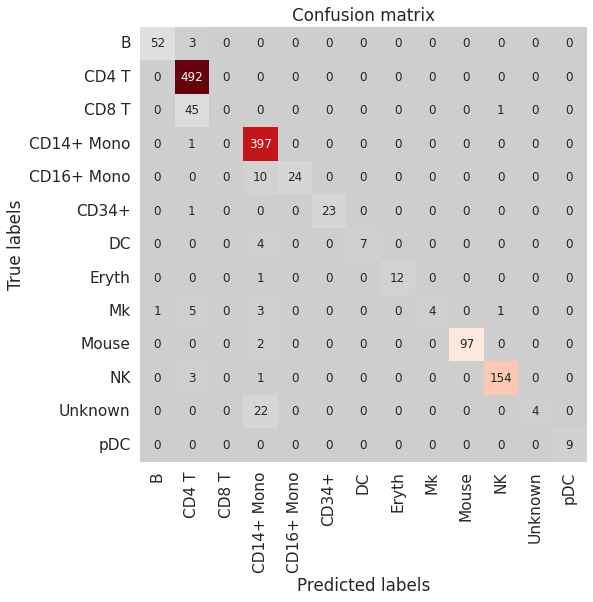

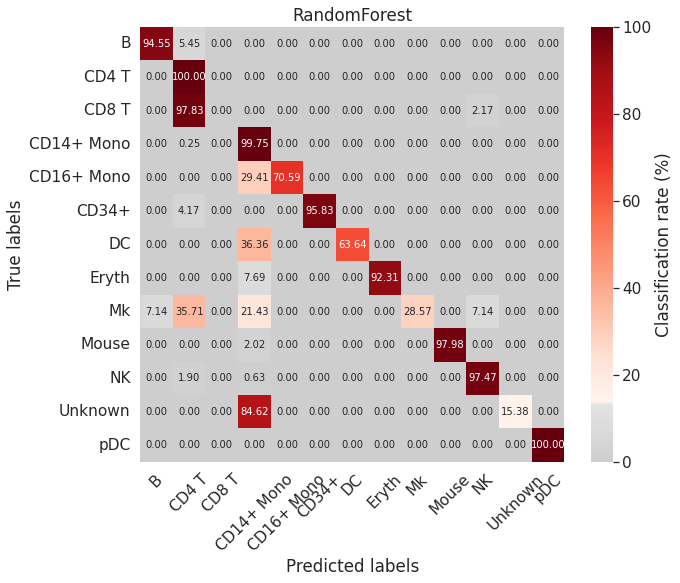

Accuracy: 0.9245830311820159: Misclassification: 0.0754169688179841
              precision    recall  f1-score   support

           B       0.98      0.95      0.96        55
       CD4 T       0.89      1.00      0.94       492
       CD8 T       0.00      0.00      0.00        46
  CD14+ Mono       0.90      1.00      0.95       398
  CD16+ Mono       1.00      0.71      0.83        34
       CD34+       1.00      0.96      0.98        24
          DC       1.00      0.64      0.78        11
       Eryth       1.00      0.92      0.96        13
          Mk       1.00      0.29      0.44        14
       Mouse       1.00      0.98      0.99        99
          NK       0.99      0.97      0.98       158
     Unknown       1.00      0.15      0.27        26
         pDC       1.00      1.00      1.00         9

    accuracy                           0.92      1379
   macro avg       0.91      0.74      0.78      1379
weighted avg       0.90      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

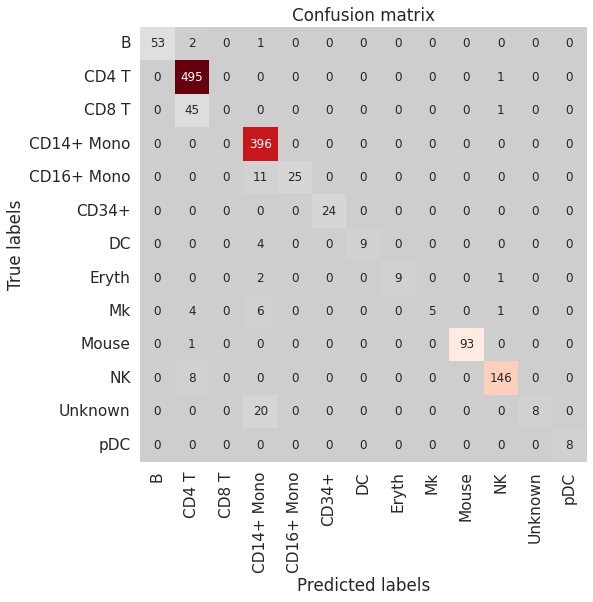

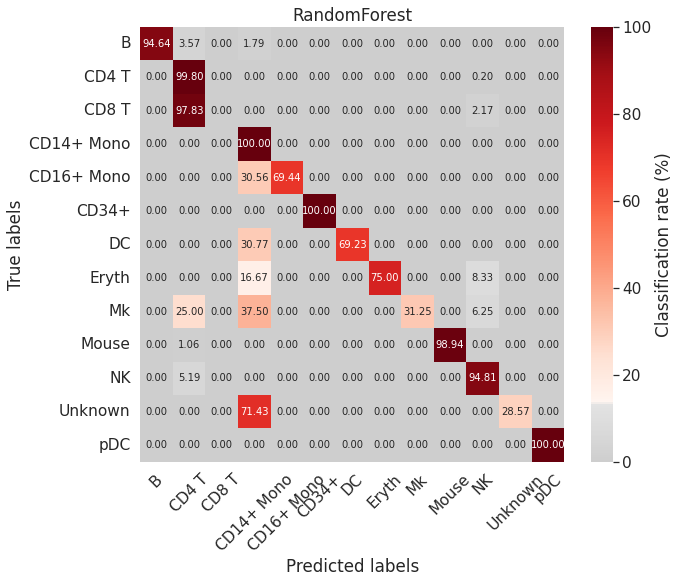

Accuracy: 0.9216823785351704: Misclassification: 0.07831762146482957
              precision    recall  f1-score   support

           B       1.00      0.95      0.97        56
       CD4 T       0.89      1.00      0.94       496
       CD8 T       0.00      0.00      0.00        46
  CD14+ Mono       0.90      1.00      0.95       396
  CD16+ Mono       1.00      0.69      0.82        36
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.69      0.82        13
       Eryth       1.00      0.75      0.86        12
          Mk       1.00      0.31      0.48        16
       Mouse       1.00      0.99      0.99        94
          NK       0.97      0.95      0.96       154
     Unknown       1.00      0.29      0.44        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.91      0.74      0.79      1379
weighted avg       0.90      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

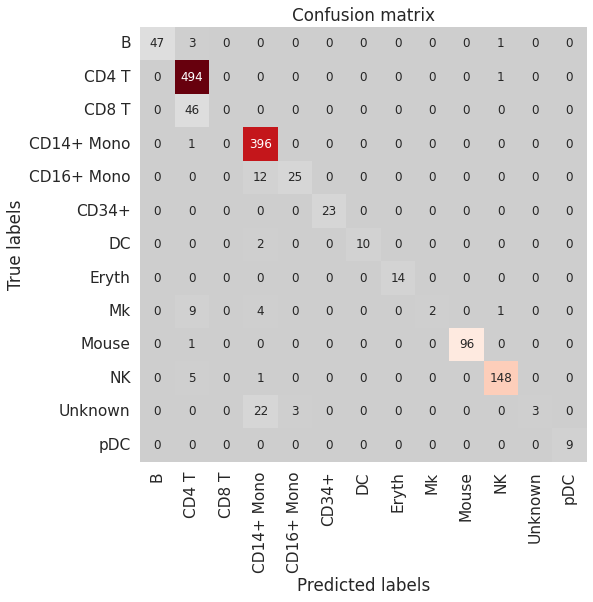

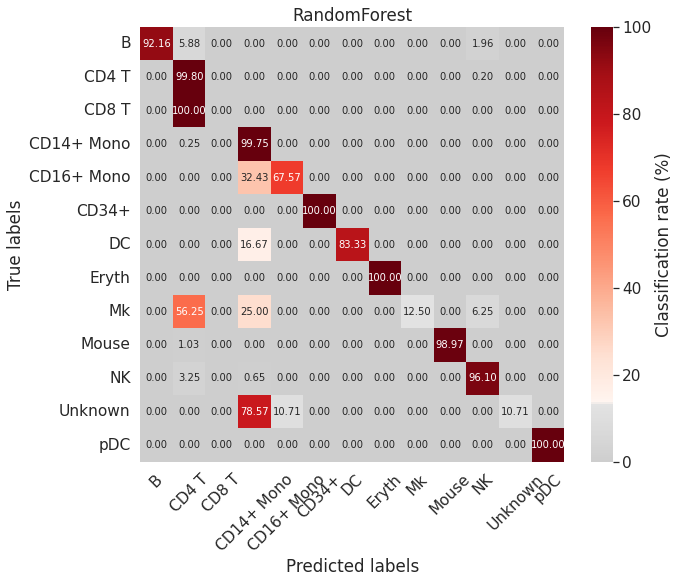

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       1.00      0.92      0.96        51
       CD4 T       0.88      1.00      0.94       495
       CD8 T       0.00      0.00      0.00        46
  CD14+ Mono       0.91      1.00      0.95       397
  CD16+ Mono       0.89      0.68      0.77        37
       CD34+       1.00      1.00      1.00        23
          DC       1.00      0.83      0.91        12
       Eryth       1.00      1.00      1.00        14
          Mk       1.00      0.12      0.22        16
       Mouse       1.00      0.99      0.99        97
          NK       0.98      0.96      0.97       154
     Unknown       1.00      0.11      0.19        28
         pDC       1.00      1.00      1.00         9

    accuracy                           0.92      1379
   macro avg       0.90      0.74      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

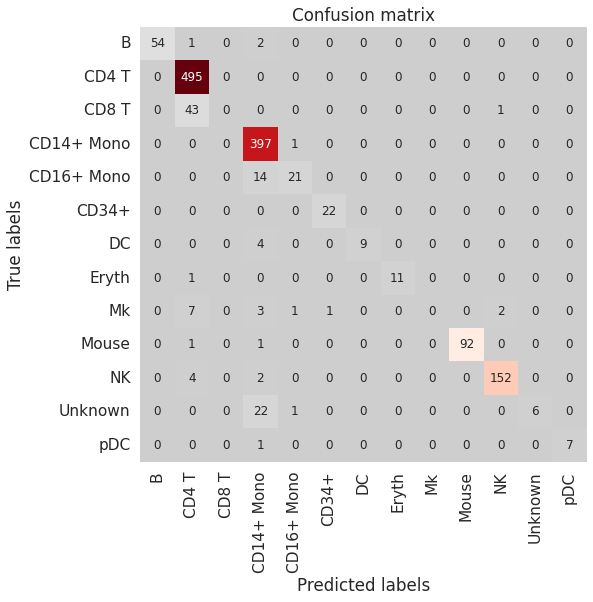

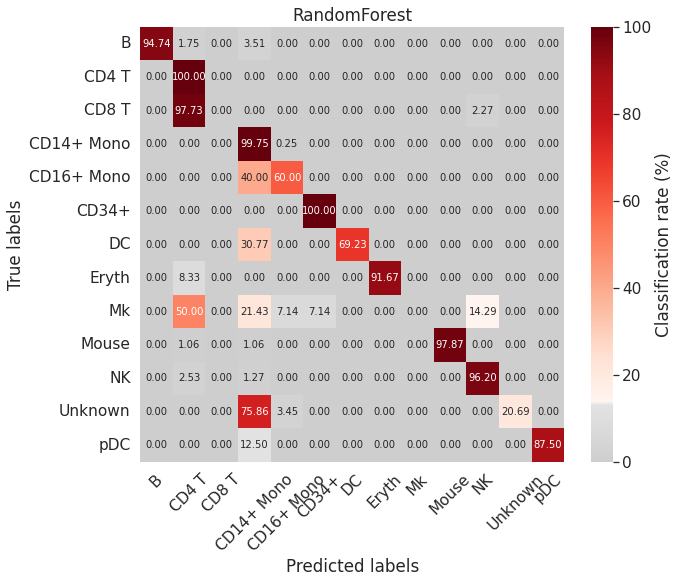

Accuracy: 0.9180565627266135: Misclassification: 0.08194343727338649
              precision    recall  f1-score   support

           B       1.00      0.95      0.97        57
       CD4 T       0.90      1.00      0.95       495
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.89      1.00      0.94       398
  CD16+ Mono       0.88      0.60      0.71        35
       CD34+       0.96      1.00      0.98        22
          DC       1.00      0.69      0.82        13
       Eryth       1.00      0.92      0.96        12
          Mk       0.00      0.00      0.00        14
       Mouse       1.00      0.98      0.99        94
          NK       0.98      0.96      0.97       158
     Unknown       1.00      0.21      0.34        29
         pDC       1.00      0.88      0.93         8

    accuracy                           0.92      1379
   macro avg       0.82      0.71      0.74      1379
weighted avg       0.88      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

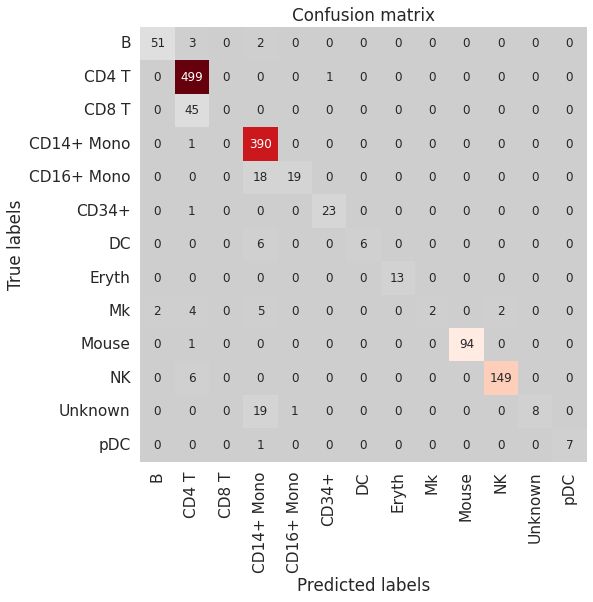

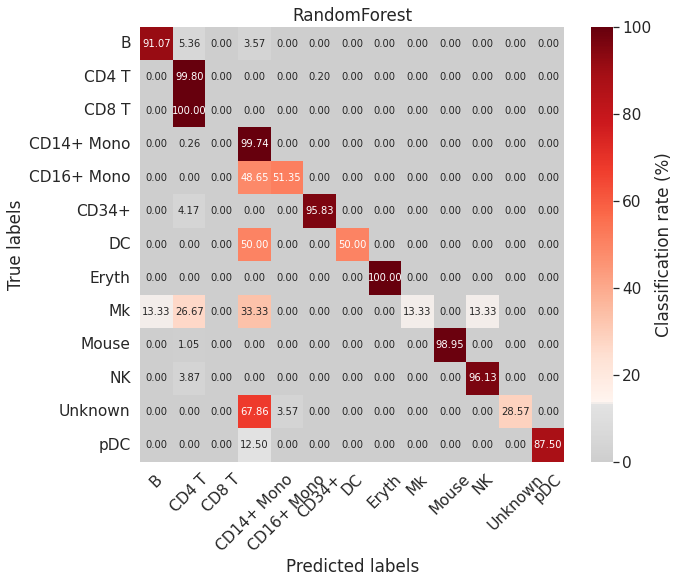

Accuracy: 0.9144307469180566: Misclassification: 0.08556925308194341
              precision    recall  f1-score   support

           B       0.96      0.91      0.94        56
       CD4 T       0.89      1.00      0.94       500
       CD8 T       0.00      0.00      0.00        45
  CD14+ Mono       0.88      1.00      0.94       391
  CD16+ Mono       0.95      0.51      0.67        37
       CD34+       0.96      0.96      0.96        24
          DC       1.00      0.50      0.67        12
       Eryth       1.00      1.00      1.00        13
          Mk       1.00      0.13      0.24        15
       Mouse       1.00      0.99      0.99        95
          NK       0.99      0.96      0.97       155
     Unknown       1.00      0.29      0.44        28
         pDC       1.00      0.88      0.93         8

    accuracy                           0.91      1379
   macro avg       0.89      0.70      0.75      1379
weighted avg       0.89      0.91      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

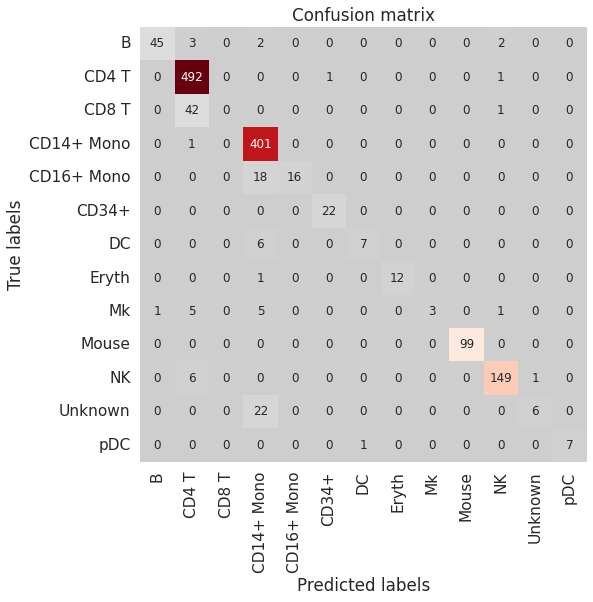

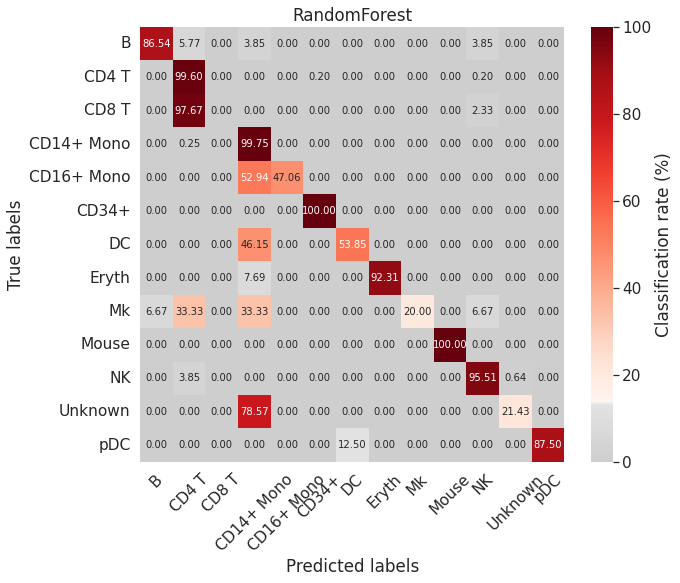

Accuracy: 0.9129804205946338: Misclassification: 0.0870195794053662
              precision    recall  f1-score   support

           B       0.98      0.87      0.92        52
       CD4 T       0.90      1.00      0.94       494
       CD8 T       0.00      0.00      0.00        43
  CD14+ Mono       0.88      1.00      0.94       402
  CD16+ Mono       1.00      0.47      0.64        34
       CD34+       0.96      1.00      0.98        22
          DC       0.88      0.54      0.67        13
       Eryth       1.00      0.92      0.96        13
          Mk       1.00      0.20      0.33        15
       Mouse       1.00      1.00      1.00        99
          NK       0.97      0.96      0.96       156
     Unknown       0.86      0.21      0.34        28
         pDC       1.00      0.88      0.93         8

    accuracy                           0.91      1379
   macro avg       0.88      0.70      0.74      1379
weighted avg       0.89      0.91      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


CPU times: user 9min 33s, sys: 12.9 s, total: 9min 46s
Wall time: 6min 51s


In [16]:
%%time
k = 50
for tryy in range(1,num_times+1):
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers)

## Train Smash DNN

the data is treated a bit differently than our other models

 * Initialising ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                16032     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 

69/69 [==============================] - 0s 5ms/step - loss: 0.6585 - accuracy: 0.7537 - auc: 0.9817 - precision: 0.9247 - recall: 0.3972 - val_loss: 0.6936 - val_accuracy: 0.8683 - val_auc: 0.9937 - val_precision: 0.9610 - val_recall: 0.5145

Epoch 00018: val_loss improved from 0.76736 to 0.69364, saving model to weights/best_model_annotation.h5
Epoch 19/100
69/69 [==============================] - 0s 5ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 5ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved f

Epoch 42/100
69/69 [==============================] - 0s 5ms/step - loss: 0.2241 - accuracy: 0.8984 - auc: 0.9962 - precision: 0.9310 - recall: 0.8477 - val_loss: 0.2626 - val_accuracy: 0.9240 - val_auc: 0.9972 - val_precision: 0.9354 - val_recall: 0.9066

Epoch 00042: val_loss improved from 0.26873 to 0.26261, saving model to weights/best_model_annotation.h5
Epoch 43/100
69/69 [==============================] - 0s 5ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 5ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to w

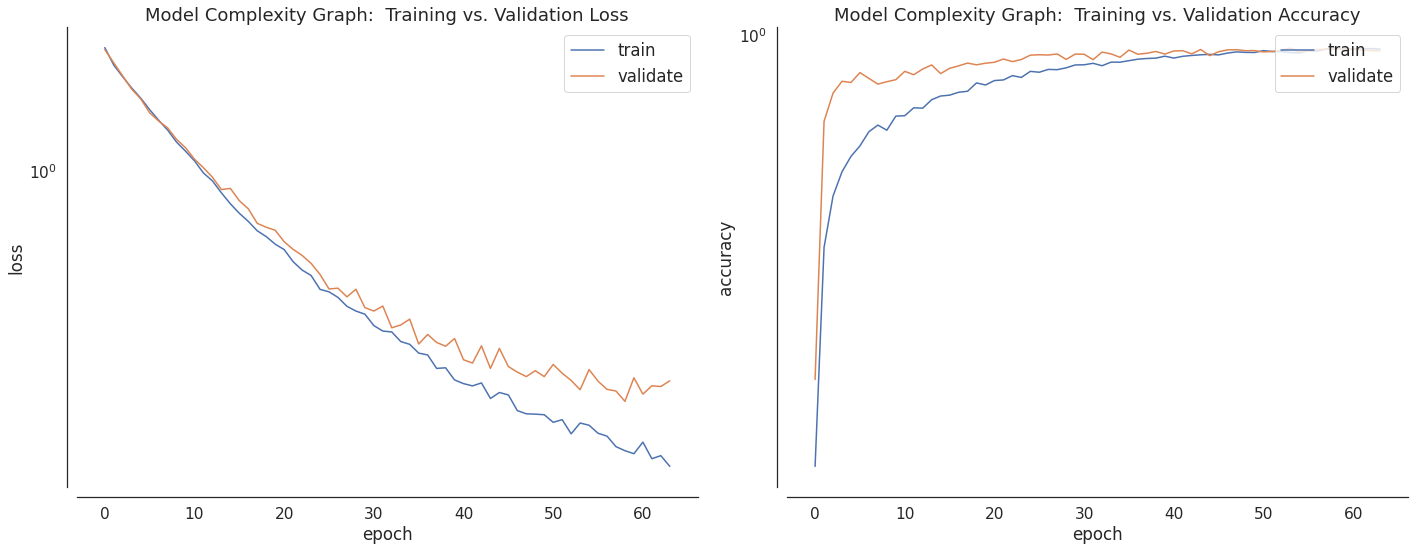

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

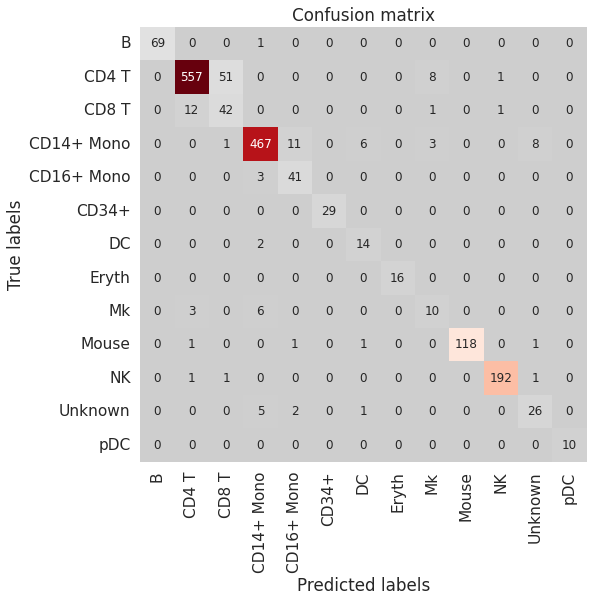

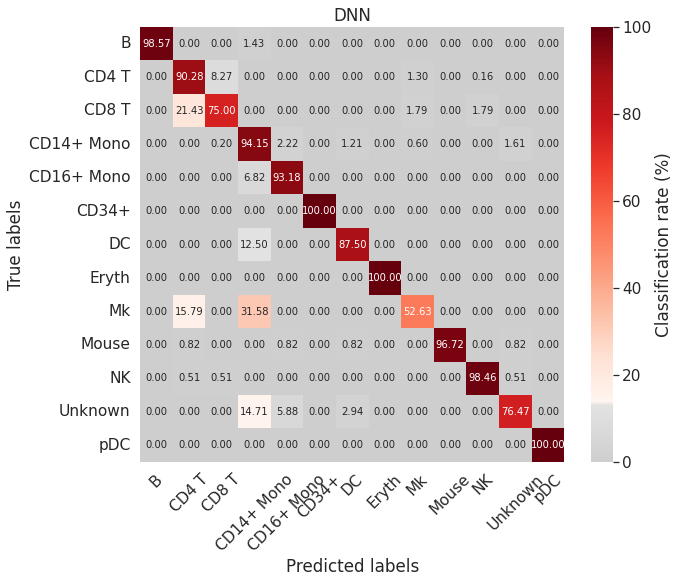

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 2ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


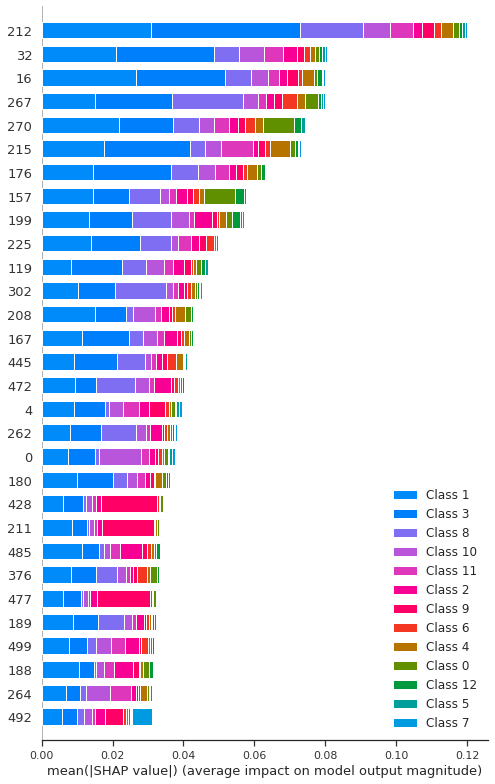

 * Initialising ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                16032     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
activation_5 (Activation)    (None

69/69 [==============================] - 0s 6ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 6ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 5ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 5ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 5ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 6ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

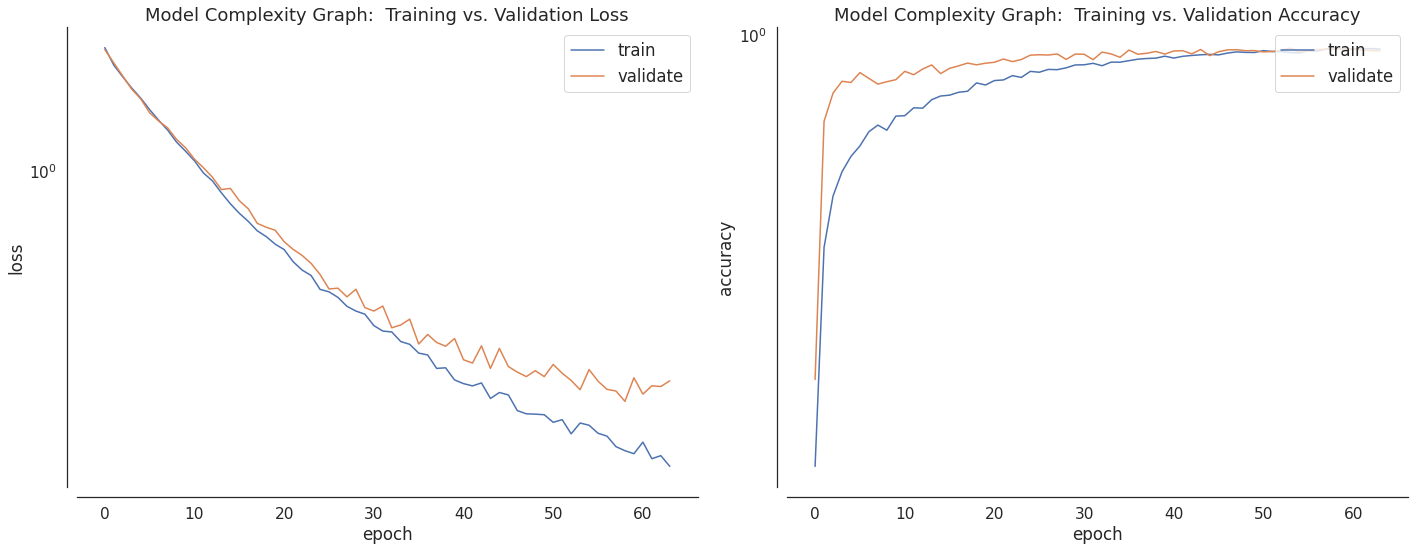

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

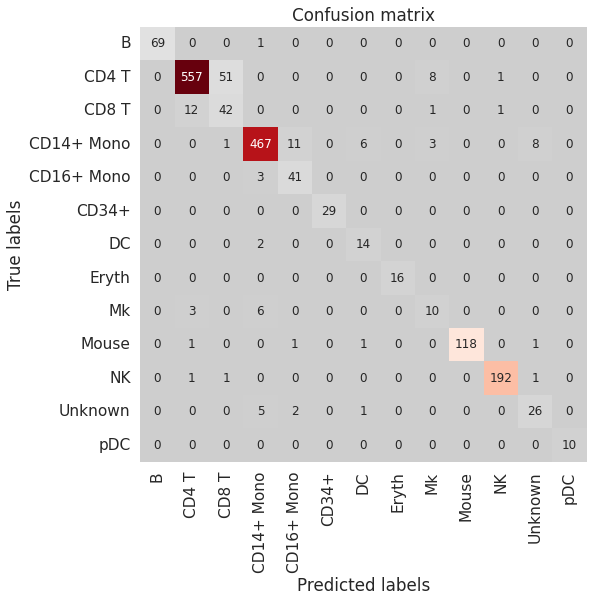

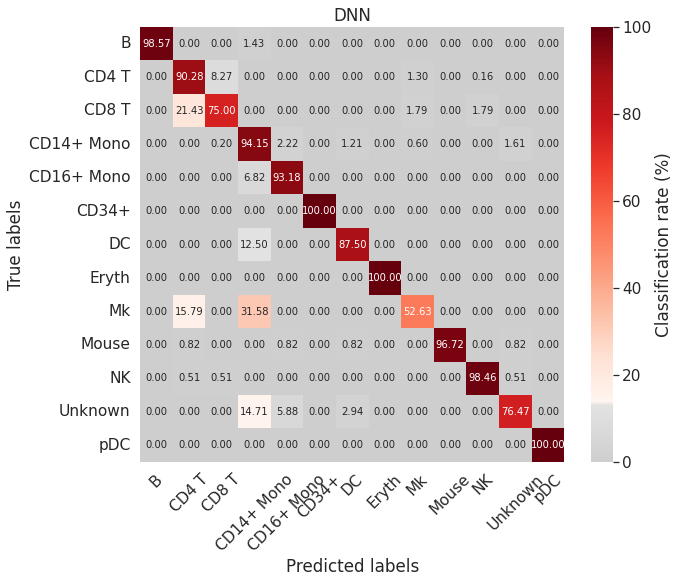

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 3ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


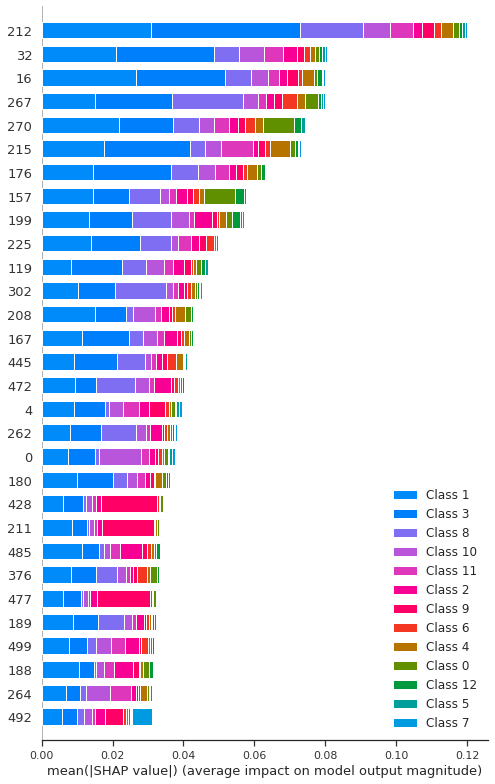

 * Initialising ...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
activation_9 (Activation)    (None

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 4ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 4ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

Epoch 43/100
69/69 [==============================] - 0s 5ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 5ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 4ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [==

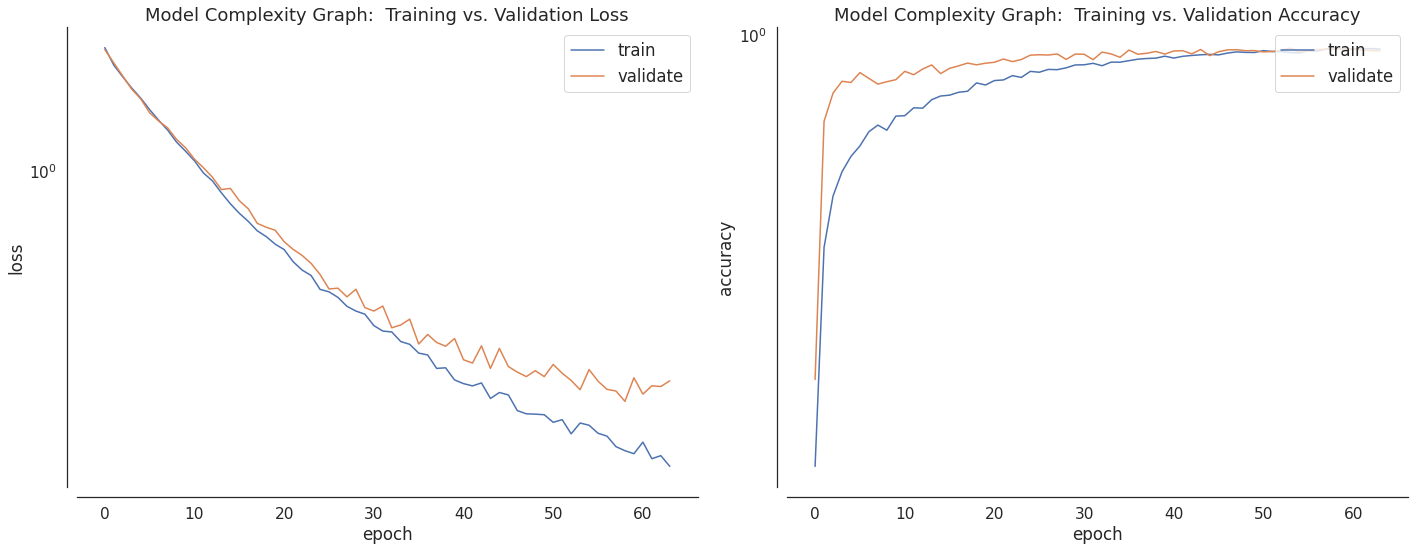

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

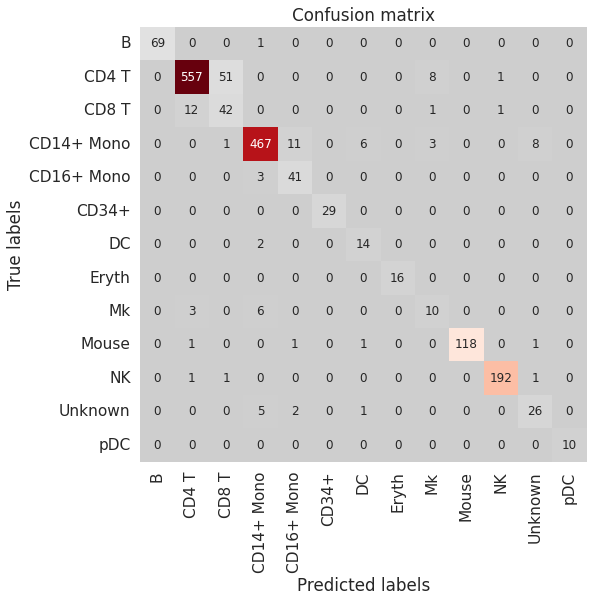

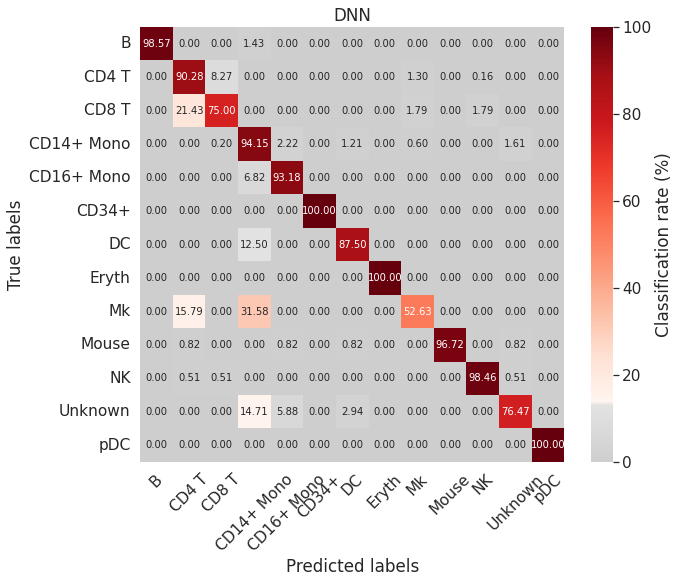

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


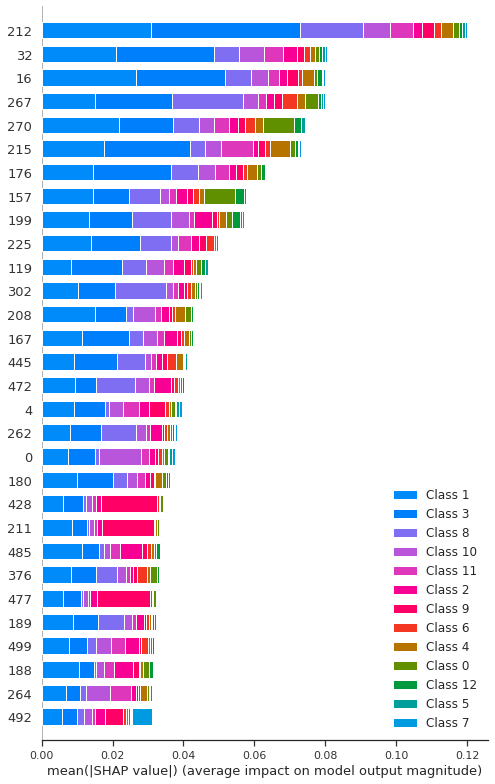

 * Initialising ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_13 (Batc (None, 16)                64        
_________________________________________________________________
activation_13 (Activation)   (None

69/69 [==============================] - 0s 5ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 5ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 5ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 5ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 5ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 5ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

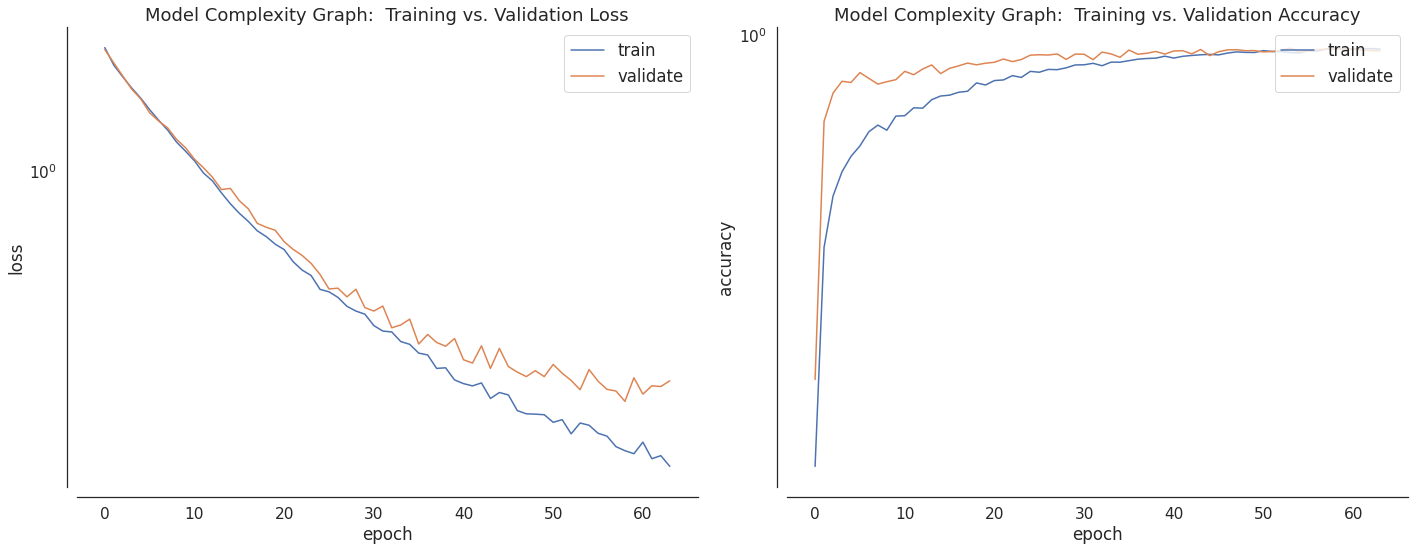

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

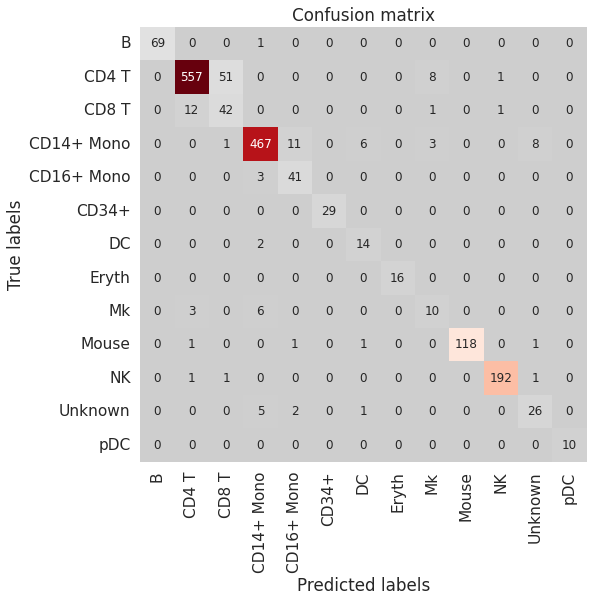

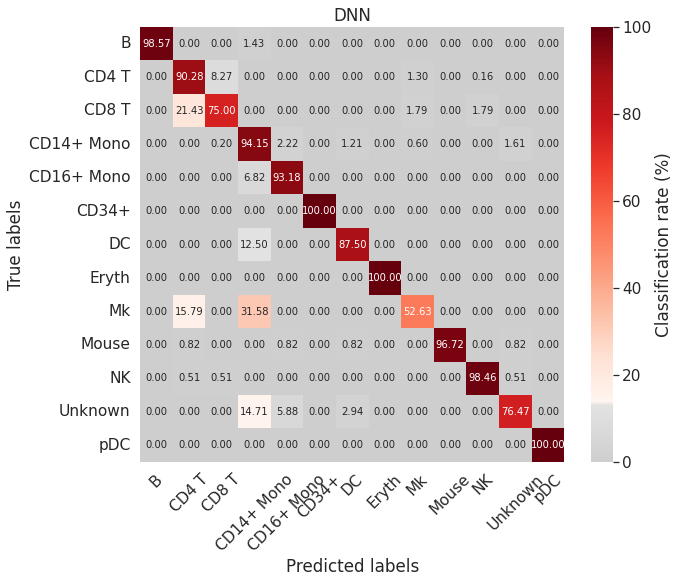

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 2ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


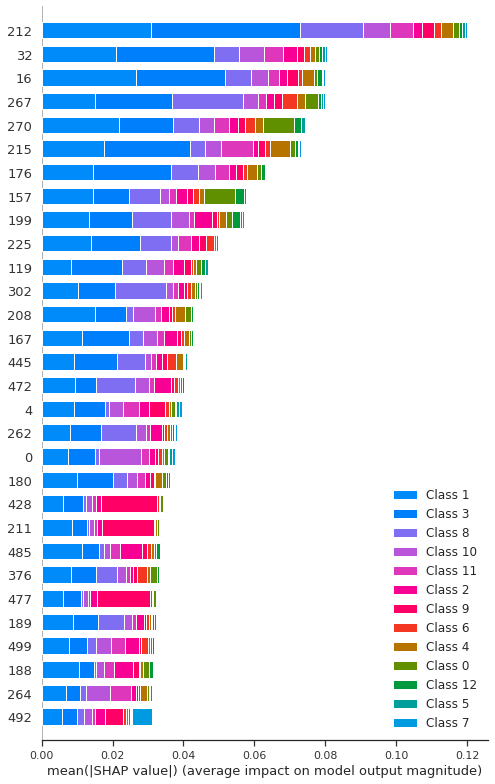

 * Initialising ...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_17 (Batc (None, 16)                64        
_________________________________________________________________
activation_17 (Activation)   (None

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

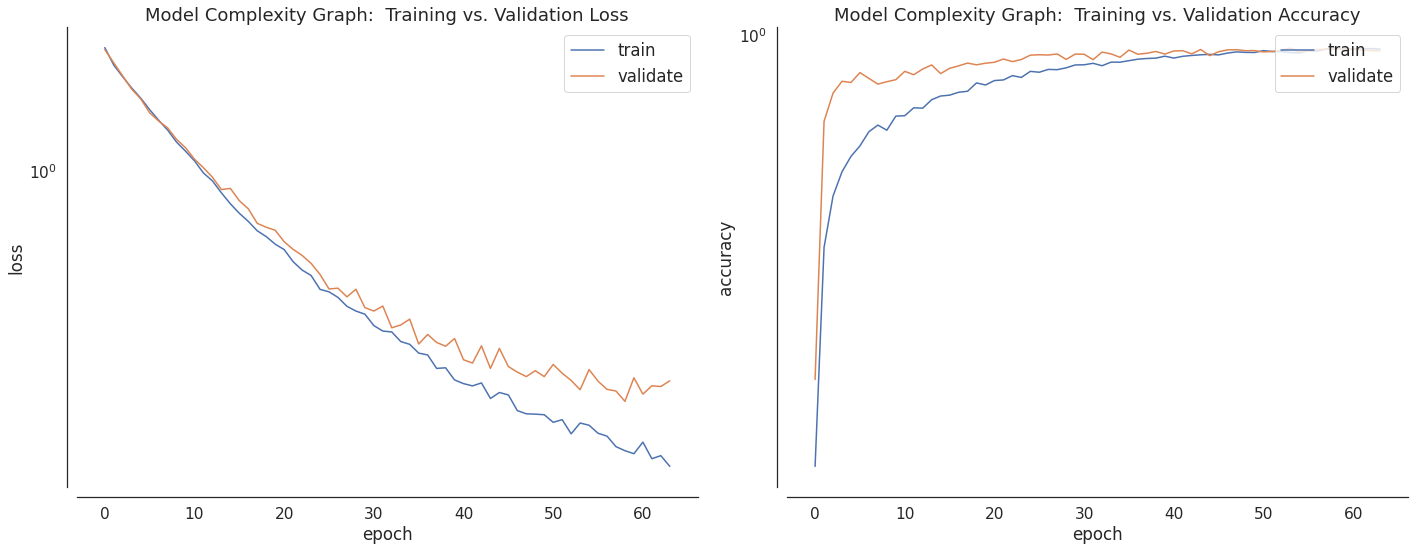

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

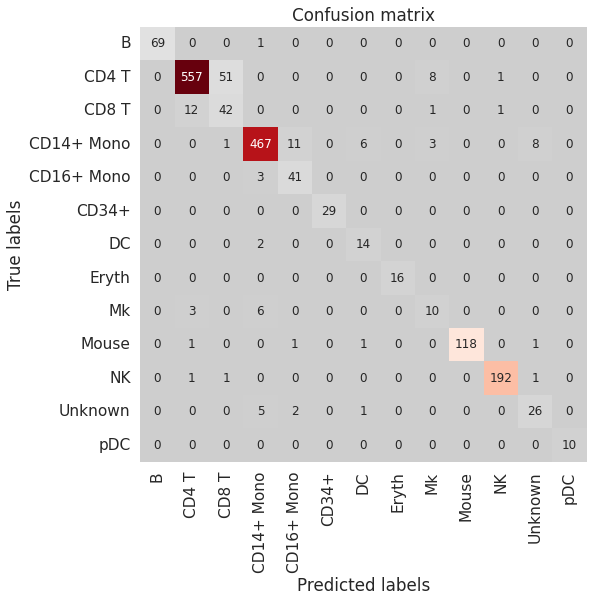

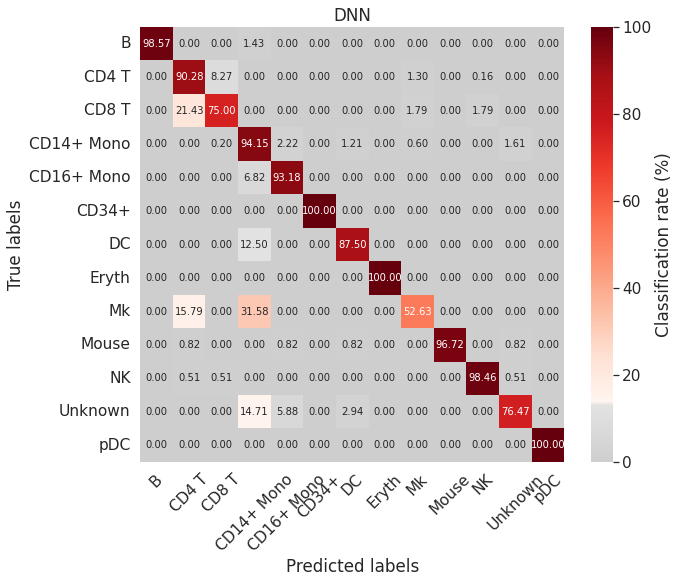

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


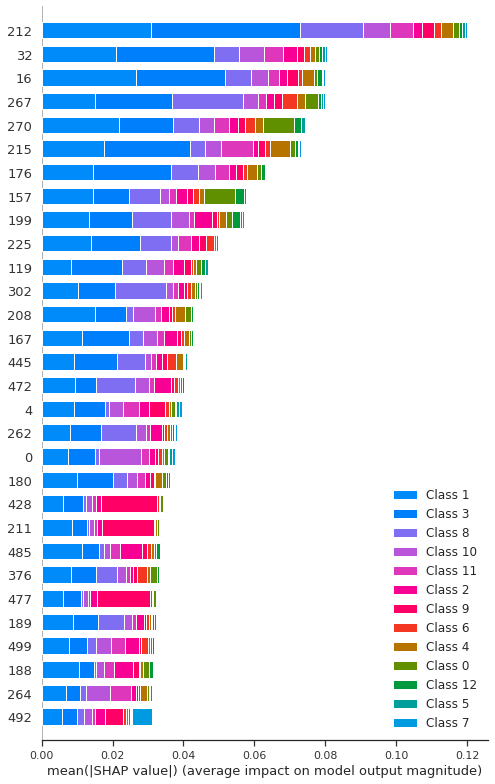

CPU times: user 8min 14s, sys: 11.8 s, total: 8min 26s
Wall time: 6min 7s


In [17]:
%%time
for k in k_range:
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(citeseq_adata, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(citeseq_adata, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'smash_markers_k_{}.npy'.format(k), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_k_{}.png'.format(k), markers = smash_markers)

 * Initialising ...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
activation_20 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_21 (Batc (None, 16)                64        
_________________________________________________________________
activation_21 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7861 - accuracy: 0.7403 - auc: 0.9779 - precision: 0.9413 - recall: 0.2940 - val_loss: 0.8352 - val_accuracy: 0.8528 - val_auc: 0.9909 - val_precision: 0.9694 - val_recall: 0.3445

Epoch 00019: val_loss improved from 0.87855 to 0.83516, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7426 - accuracy: 0.7564 - auc: 0.9801 - precision: 0.9512 - recall: 0.3361 - val_loss: 0.8267 - val_accuracy: 0.8419 - val_auc: 0.9899 - val_precision: 0.9554 - val_recall: 0.3727

Epoch 00020: val_loss improved from 0.83516 to 0.82670, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.6903 - accuracy: 0.7677 - auc: 0.9828 - precision: 0.9443 - recall: 0.3721 - val_loss: 0.7677 - val_accuracy: 0.8513 - val_auc: 0.9910 - val_precision: 0.9432 - val_recall: 0.4213

Epoch 00021: val_loss improved f


Epoch 00042: val_loss did not improve from 0.37119
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2784 - accuracy: 0.8876 - auc: 0.9953 - precision: 0.9367 - recall: 0.8056 - val_loss: 0.3404 - val_accuracy: 0.9072 - val_auc: 0.9962 - val_precision: 0.9270 - val_recall: 0.8745

Epoch 00043: val_loss improved from 0.37119 to 0.34037, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2771 - accuracy: 0.8937 - auc: 0.9957 - precision: 0.9388 - recall: 0.8172 - val_loss: 0.3239 - val_accuracy: 0.9094 - val_auc: 0.9960 - val_precision: 0.9305 - val_recall: 0.8840

Epoch 00044: val_loss improved from 0.34037 to 0.32394, saving model to weights/best_model_annotation.h5
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2576 - accuracy: 0.8974 - auc: 0.9958 - precision: 0.9403 - recall: 0.8313 - val_loss: 0.3194 - val_accuracy: 0.9094 - val_auc: 0.9964 - val_precisi

56/56 [==============================] - 0s 3ms/step - loss: 0.1474 - accuracy: 0.9347 - auc: 0.9983 - precision: 0.9539 - recall: 0.9082 - val_loss: 0.2483 - val_accuracy: 0.9202 - val_auc: 0.9959 - val_precision: 0.9253 - val_recall: 0.9072

Epoch 00067: val_loss improved from 0.24840 to 0.24831, saving model to weights/best_model_annotation.h5
Epoch 68/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1483 - accuracy: 0.9374 - auc: 0.9984 - precision: 0.9589 - recall: 0.9086 - val_loss: 0.2482 - val_accuracy: 0.9188 - val_auc: 0.9959 - val_precision: 0.9261 - val_recall: 0.9086

Epoch 00068: val_loss improved from 0.24831 to 0.24824, saving model to weights/best_model_annotation.h5
Epoch 69/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1401 - accuracy: 0.9400 - auc: 0.9983 - precision: 0.9599 - recall: 0.9157 - val_loss: 0.2541 - val_accuracy: 0.9166 - val_auc: 0.9957 - val_precision: 0.9232 - val_recall: 0.9072

Epoch 00069: val_loss did not im

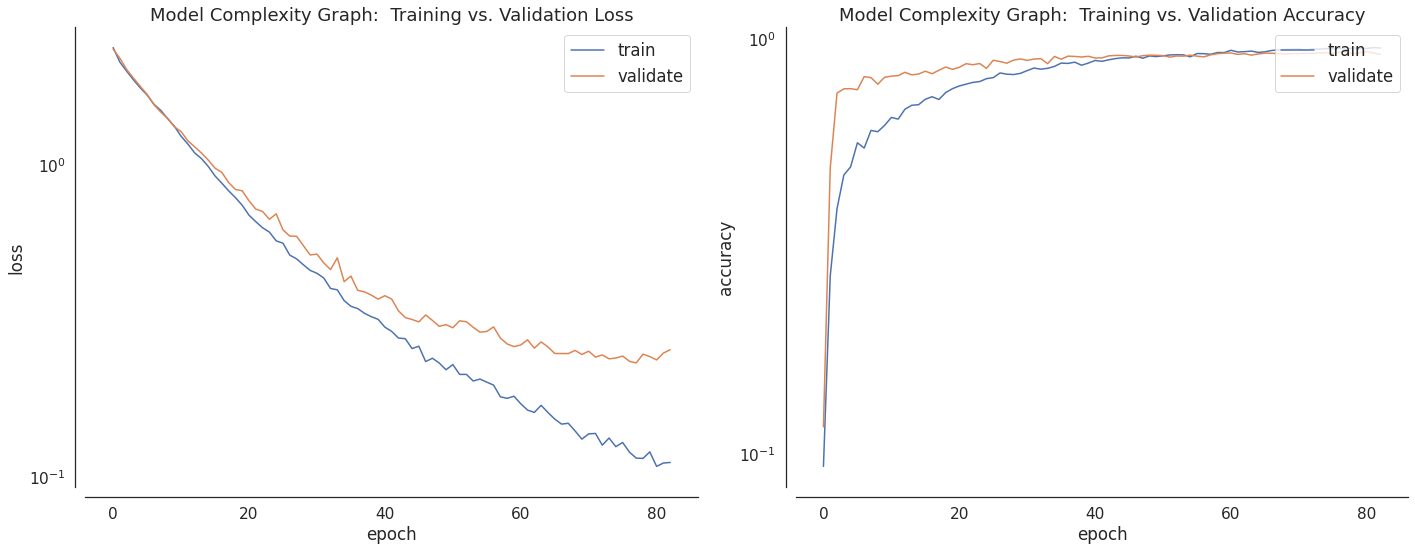

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

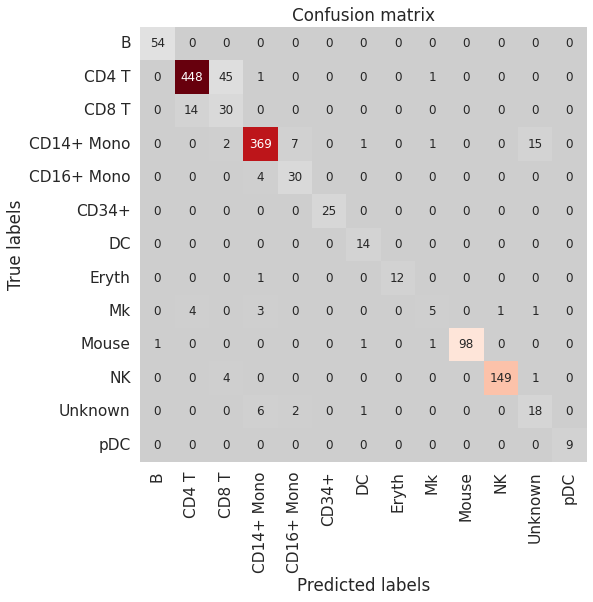

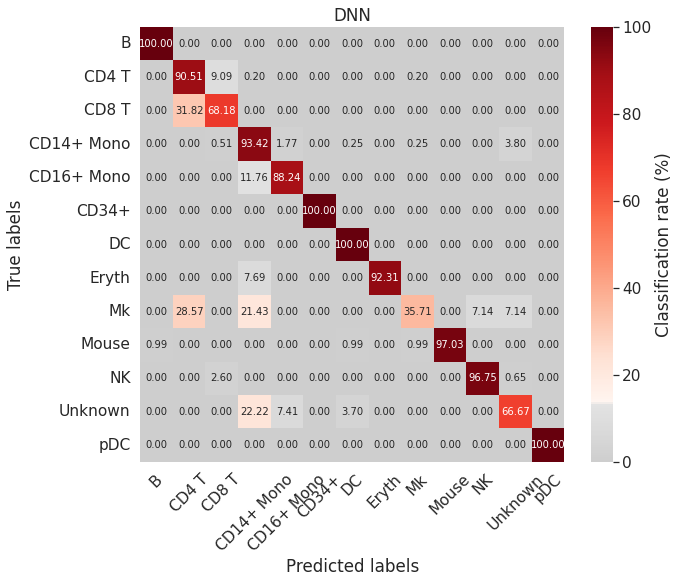

              precision    recall  f1-score   support

           B       0.98      1.00      0.99        54
       CD4 T       0.96      0.91      0.93       495
       CD8 T       0.37      0.68      0.48        44
  CD14+ Mono       0.96      0.93      0.95       395
  CD16+ Mono       0.77      0.88      0.82        34
       CD34+       1.00      1.00      1.00        25
          DC       0.82      1.00      0.90        14
       Eryth       1.00      0.92      0.96        13
          Mk       0.62      0.36      0.45        14
       Mouse       1.00      0.97      0.98       101
          NK       0.99      0.97      0.98       154
     Unknown       0.51      0.67      0.58        27
         pDC       1.00      1.00      1.00         9

    accuracy                           0.91      1379
   macro avg       0.85      0.87      0.85      1379
weighted avg       0.93      0.91      0.92      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2317 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


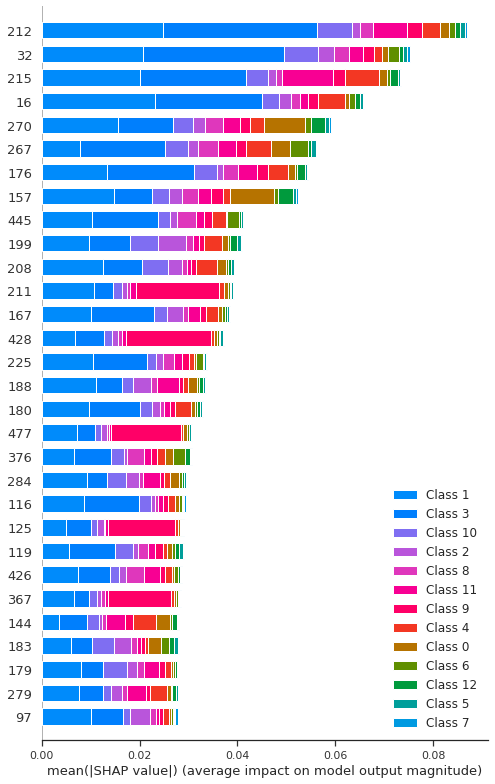

 * Initialising ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_24 (Batc (None, 32)                128       
_________________________________________________________________
activation_24 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_25 (Batc (None, 16)                64        
_________________________________________________________________
activation_25 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7838 - accuracy: 0.7374 - auc: 0.9779 - precision: 0.9485 - recall: 0.3139 - val_loss: 0.9078 - val_accuracy: 0.8245 - val_auc: 0.9868 - val_precision: 0.9638 - val_recall: 0.3278

Epoch 00019: val_loss did not improve from 0.90248
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7339 - accuracy: 0.7481 - auc: 0.9798 - precision: 0.9544 - recall: 0.3301 - val_loss: 0.8395 - val_accuracy: 0.8455 - val_auc: 0.9890 - val_precision: 0.9518 - val_recall: 0.3582

Epoch 00020: val_loss improved from 0.90248 to 0.83948, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.7673 - auc: 0.9820 - precision: 0.9491 - recall: 0.3754 - val_loss: 0.7570 - val_accuracy: 0.8702 - val_auc: 0.9910 - val_precision: 0.9647 - val_recall: 0.4561

Epoch 00021: val_loss improved from 0.83948 to 0.75698, saving model to weights/best_m

56/56 [==============================] - 0s 3ms/step - loss: 0.2771 - accuracy: 0.8964 - auc: 0.9960 - precision: 0.9412 - recall: 0.8123 - val_loss: 0.3745 - val_accuracy: 0.9028 - val_auc: 0.9937 - val_precision: 0.9302 - val_recall: 0.8702

Epoch 00043: val_loss improved from 0.37958 to 0.37450, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2742 - accuracy: 0.8945 - auc: 0.9960 - precision: 0.9433 - recall: 0.8212 - val_loss: 0.3472 - val_accuracy: 0.9144 - val_auc: 0.9939 - val_precision: 0.9320 - val_recall: 0.8847

Epoch 00044: val_loss improved from 0.37450 to 0.34716, saving model to weights/best_model_annotation.h5
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2631 - accuracy: 0.8977 - auc: 0.9962 - precision: 0.9380 - recall: 0.8310 - val_loss: 0.3460 - val_accuracy: 0.9108 - val_auc: 0.9940 - val_precision: 0.9269 - val_recall: 0.8825

Epoch 00045: val_loss improved f

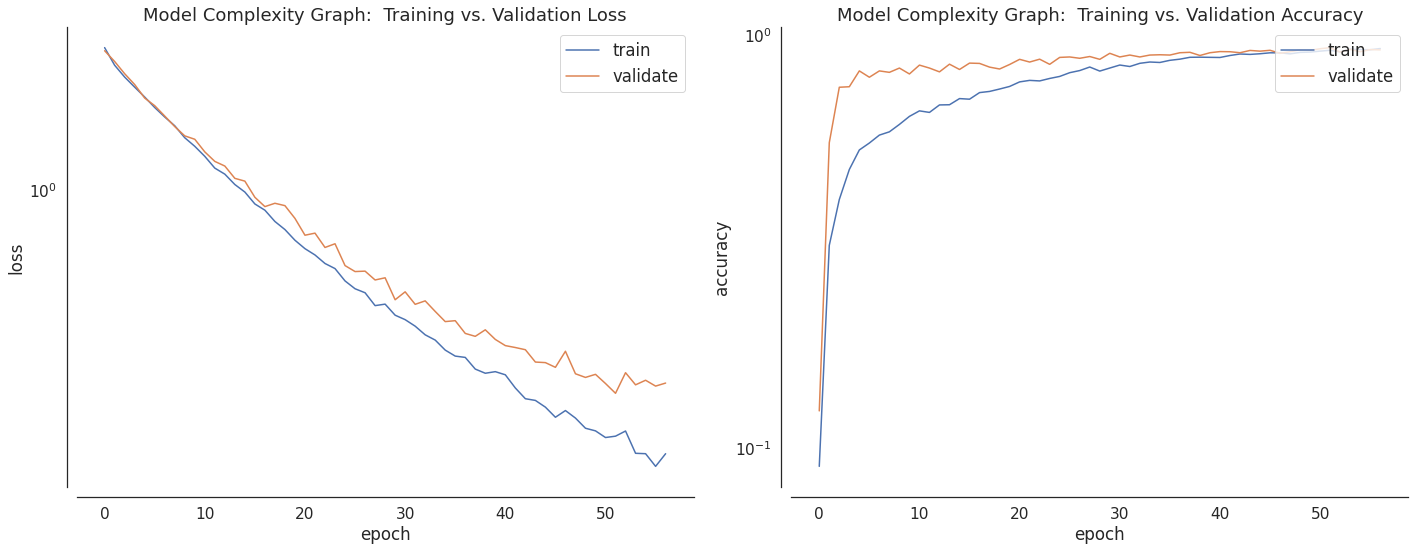

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

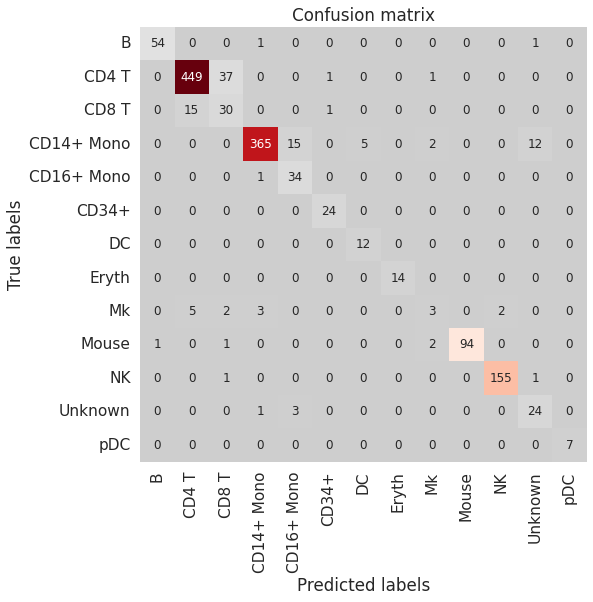

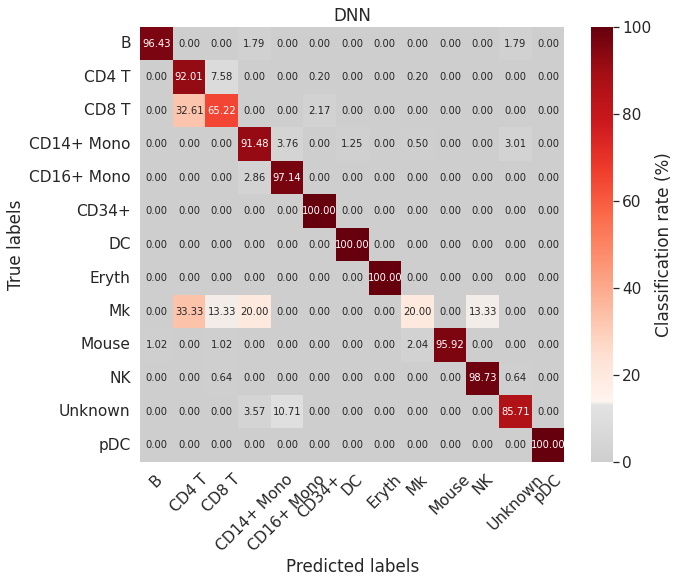

              precision    recall  f1-score   support

           B       0.98      0.96      0.97        56
       CD4 T       0.96      0.92      0.94       488
       CD8 T       0.42      0.65      0.51        46
  CD14+ Mono       0.98      0.91      0.95       399
  CD16+ Mono       0.65      0.97      0.78        35
       CD34+       0.92      1.00      0.96        24
          DC       0.71      1.00      0.83        12
       Eryth       1.00      1.00      1.00        14
          Mk       0.38      0.20      0.26        15
       Mouse       1.00      0.96      0.98        98
          NK       0.99      0.99      0.99       157
     Unknown       0.63      0.86      0.73        28
         pDC       1.00      1.00      1.00         7

    accuracy                           0.92      1379
   macro avg       0.82      0.88      0.84      1379
weighted avg       0.93      0.92      0.92      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2865 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


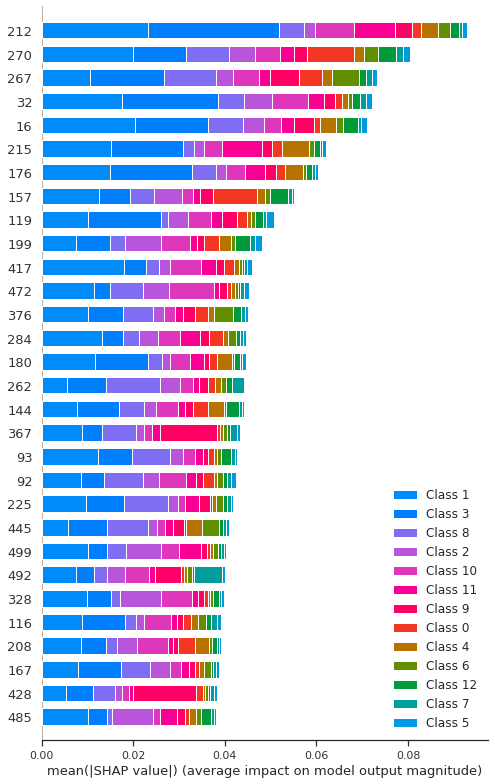

 * Initialising ...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_28 (Batc (None, 32)                128       
_________________________________________________________________
activation_28 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_29 (Batc (None, 16)                64        
_________________________________________________________________
activation_29 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7662 - accuracy: 0.7550 - auc: 0.9801 - precision: 0.9639 - recall: 0.3150 - val_loss: 0.8315 - val_accuracy: 0.8448 - val_auc: 0.9904 - val_precision: 0.9767 - val_recall: 0.3640

Epoch 00019: val_loss improved from 0.87547 to 0.83147, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7262 - accuracy: 0.7430 - auc: 0.9806 - precision: 0.9409 - recall: 0.3466 - val_loss: 0.8059 - val_accuracy: 0.8412 - val_auc: 0.9909 - val_precision: 0.9800 - val_recall: 0.3901

Epoch 00020: val_loss improved from 0.83147 to 0.80588, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.7675 - auc: 0.9825 - precision: 0.9517 - recall: 0.3787 - val_loss: 0.7637 - val_accuracy: 0.8390 - val_auc: 0.9912 - val_precision: 0.9725 - val_recall: 0.4365

Epoch 00021: val_loss improved f


Epoch 00042: val_loss did not improve from 0.33200
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2758 - accuracy: 0.8843 - auc: 0.9952 - precision: 0.9308 - recall: 0.8007 - val_loss: 0.3092 - val_accuracy: 0.9289 - val_auc: 0.9970 - val_precision: 0.9510 - val_recall: 0.8999

Epoch 00043: val_loss improved from 0.33200 to 0.30917, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2767 - accuracy: 0.8946 - auc: 0.9961 - precision: 0.9407 - recall: 0.8147 - val_loss: 0.3071 - val_accuracy: 0.9253 - val_auc: 0.9970 - val_precision: 0.9486 - val_recall: 0.8963

Epoch 00044: val_loss improved from 0.30917 to 0.30714, saving model to weights/best_model_annotation.h5
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2703 - accuracy: 0.8990 - auc: 0.9962 - precision: 0.9417 - recall: 0.8237 - val_loss: 0.3123 - val_accuracy: 0.9217 - val_auc: 0.9967 - val_precisi

56/56 [==============================] - 0s 3ms/step - loss: 0.1514 - accuracy: 0.9336 - auc: 0.9983 - precision: 0.9507 - recall: 0.9053 - val_loss: 0.2337 - val_accuracy: 0.9304 - val_auc: 0.9968 - val_precision: 0.9406 - val_recall: 0.9188

Epoch 00067: val_loss did not improve from 0.22212
Epoch 68/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1585 - accuracy: 0.9305 - auc: 0.9979 - precision: 0.9504 - recall: 0.8999 - val_loss: 0.2339 - val_accuracy: 0.9304 - val_auc: 0.9965 - val_precision: 0.9419 - val_recall: 0.9173

Epoch 00068: val_loss did not improve from 0.22212
Epoch 69/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1327 - accuracy: 0.9445 - auc: 0.9985 - precision: 0.9606 - recall: 0.9204 - val_loss: 0.2361 - val_accuracy: 0.9318 - val_auc: 0.9967 - val_precision: 0.9411 - val_recall: 0.9159

Epoch 00069: val_loss did not improve from 0.22212
Epoch 70/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1371 - accura

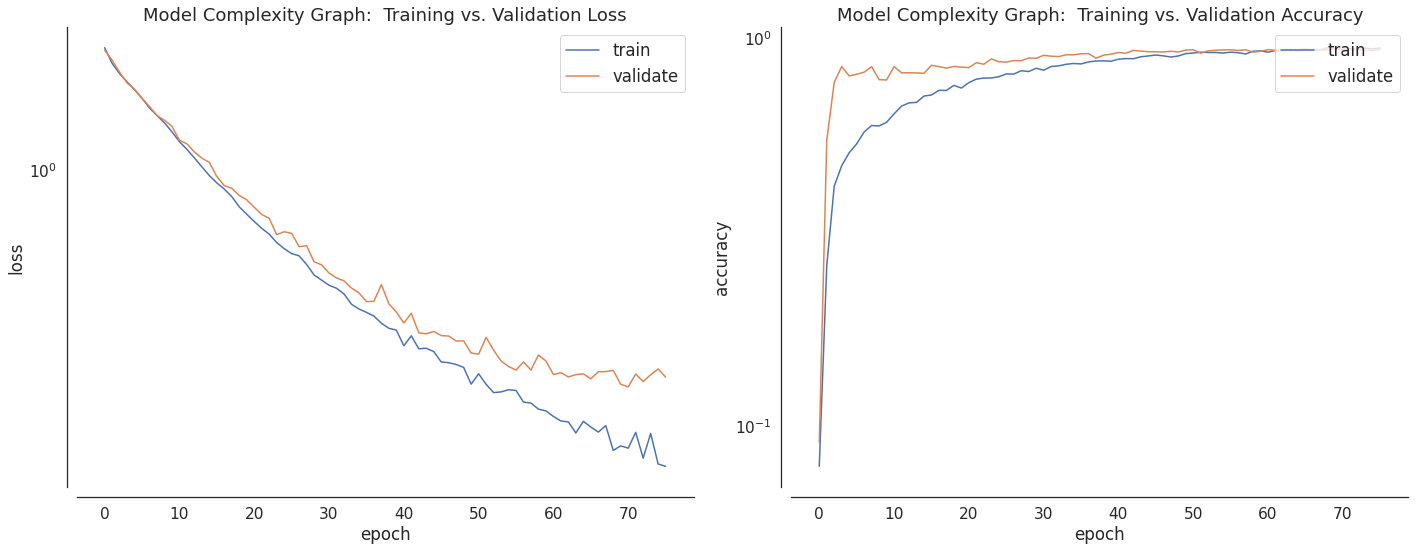

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

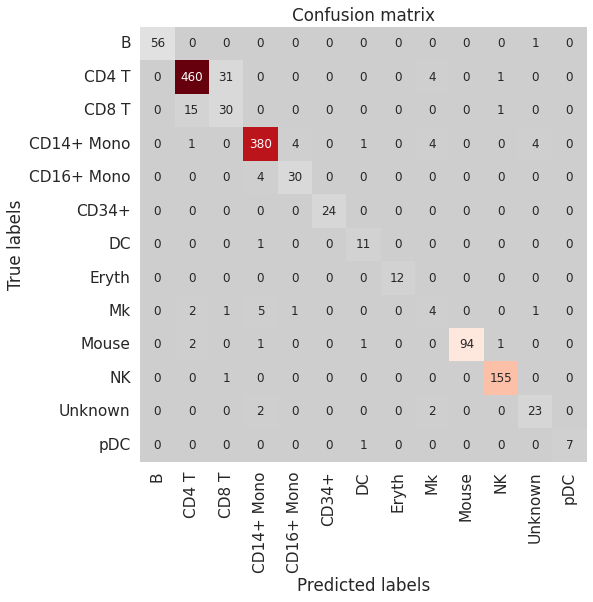

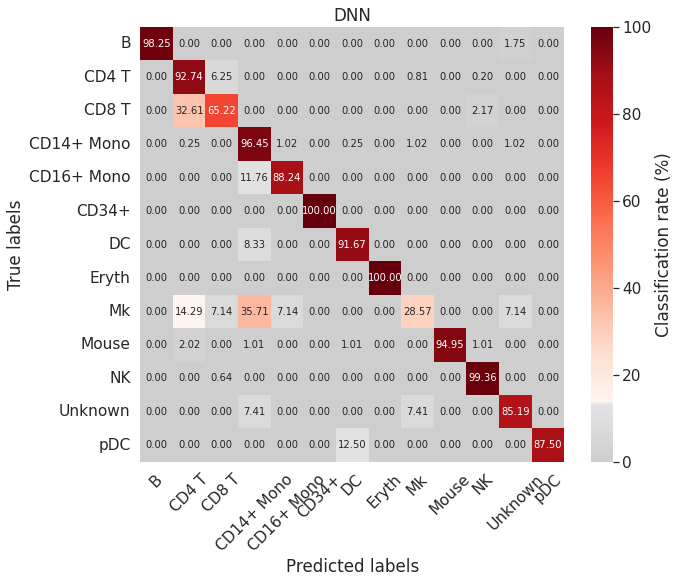

              precision    recall  f1-score   support

           B       1.00      0.98      0.99        57
       CD4 T       0.96      0.93      0.94       496
       CD8 T       0.48      0.65      0.55        46
  CD14+ Mono       0.97      0.96      0.97       394
  CD16+ Mono       0.86      0.88      0.87        34
       CD34+       1.00      1.00      1.00        24
          DC       0.79      0.92      0.85        12
       Eryth       1.00      1.00      1.00        12
          Mk       0.29      0.29      0.29        14
       Mouse       1.00      0.95      0.97        99
          NK       0.98      0.99      0.99       156
     Unknown       0.79      0.85      0.82        27
         pDC       1.00      0.88      0.93         8

    accuracy                           0.93      1379
   macro avg       0.85      0.87      0.86      1379
weighted avg       0.94      0.93      0.94      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2096 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


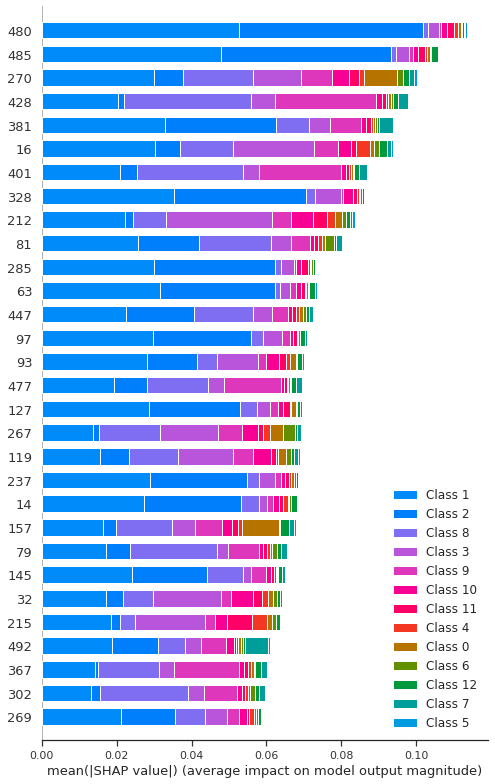

 * Initialising ...
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_32 (Batc (None, 32)                128       
_________________________________________________________________
activation_32 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_33 (Batc (None, 16)                64        
_________________________________________________________________
activation_33 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7772 - accuracy: 0.7408 - auc: 0.9795 - precision: 0.9473 - recall: 0.3034 - val_loss: 0.8291 - val_accuracy: 0.8608 - val_auc: 0.9914 - val_precision: 0.9816 - val_recall: 0.3481

Epoch 00019: val_loss improved from 0.86480 to 0.82907, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7341 - accuracy: 0.7612 - auc: 0.9815 - precision: 0.9445 - recall: 0.3304 - val_loss: 0.7595 - val_accuracy: 0.8745 - val_auc: 0.9927 - val_precision: 0.9747 - val_recall: 0.4191

Epoch 00020: val_loss improved from 0.82907 to 0.75949, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.7631 - auc: 0.9825 - precision: 0.9416 - recall: 0.3712 - val_loss: 0.7601 - val_accuracy: 0.8608 - val_auc: 0.9920 - val_precision: 0.9615 - val_recall: 0.4162

Epoch 00021: val_loss did not im

56/56 [==============================] - 0s 3ms/step - loss: 0.2974 - accuracy: 0.8812 - auc: 0.9946 - precision: 0.9305 - recall: 0.8014 - val_loss: 0.3419 - val_accuracy: 0.9065 - val_auc: 0.9962 - val_precision: 0.9322 - val_recall: 0.8774

Epoch 00042: val_loss did not improve from 0.32689
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2801 - accuracy: 0.8850 - auc: 0.9951 - precision: 0.9313 - recall: 0.8118 - val_loss: 0.3171 - val_accuracy: 0.9130 - val_auc: 0.9964 - val_precision: 0.9354 - val_recall: 0.8825

Epoch 00043: val_loss improved from 0.32689 to 0.31705, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2658 - accuracy: 0.8925 - auc: 0.9957 - precision: 0.9327 - recall: 0.8163 - val_loss: 0.3243 - val_accuracy: 0.9094 - val_auc: 0.9962 - val_precision: 0.9261 - val_recall: 0.8818

Epoch 00044: val_loss did not improve from 0.31705
Epoch 45/100
56/56 [===============

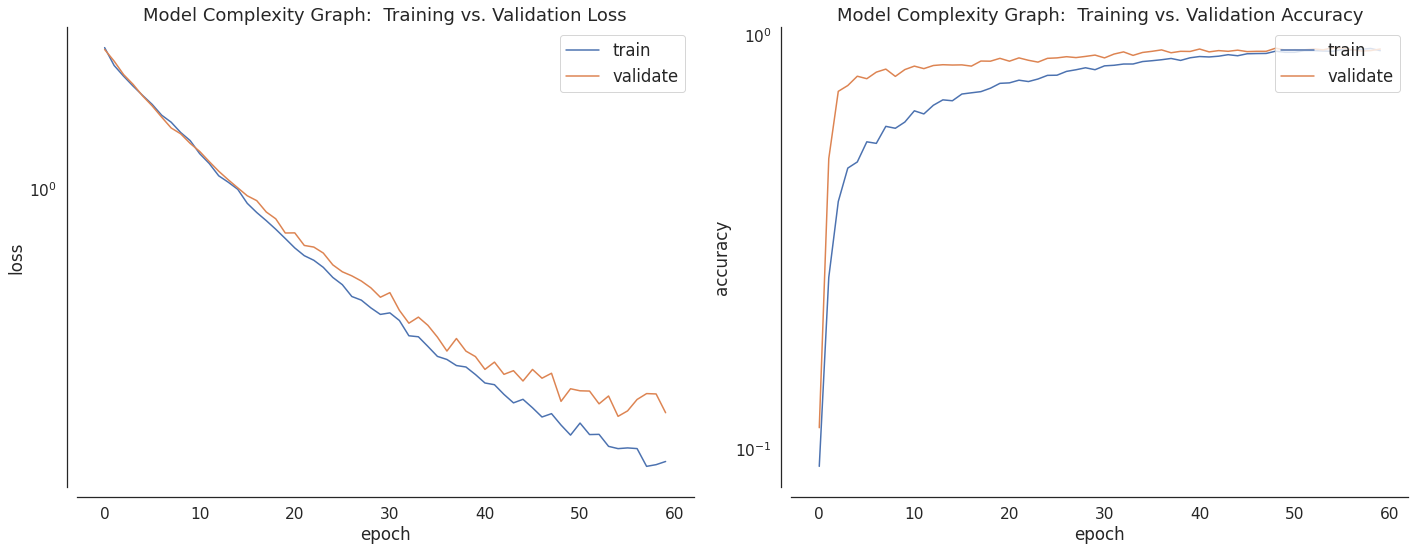

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

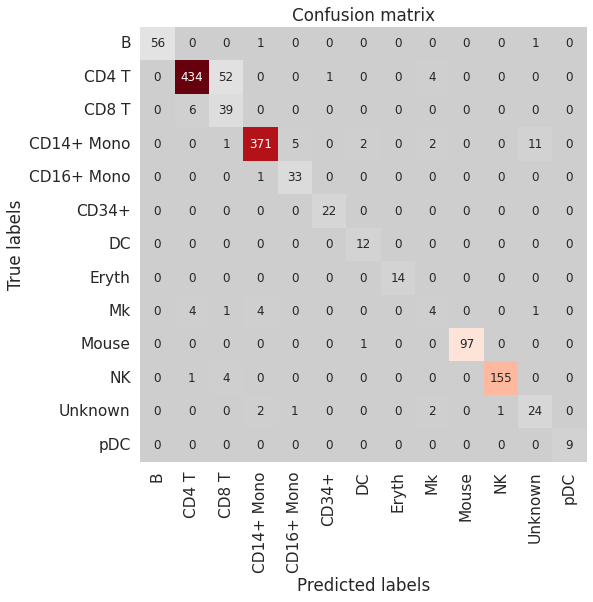

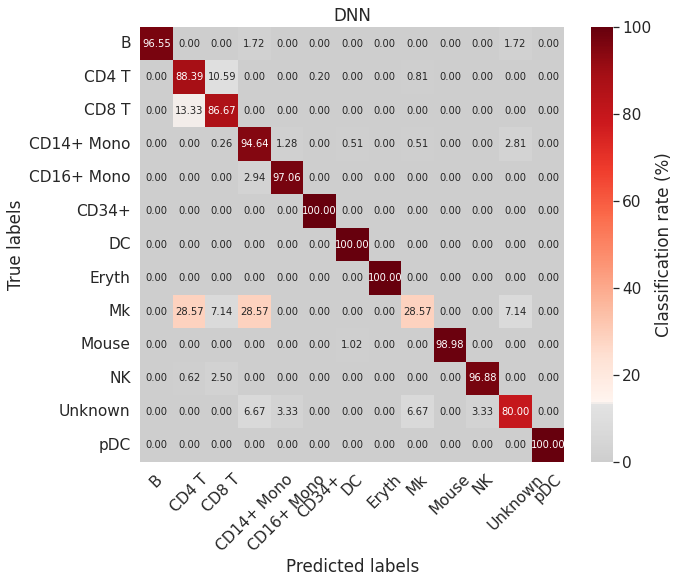

              precision    recall  f1-score   support

           B       1.00      0.97      0.98        58
       CD4 T       0.98      0.88      0.93       491
       CD8 T       0.40      0.87      0.55        45
  CD14+ Mono       0.98      0.95      0.96       392
  CD16+ Mono       0.85      0.97      0.90        34
       CD34+       0.96      1.00      0.98        22
          DC       0.80      1.00      0.89        12
       Eryth       1.00      1.00      1.00        14
          Mk       0.33      0.29      0.31        14
       Mouse       1.00      0.99      0.99        98
          NK       0.99      0.97      0.98       160
     Unknown       0.65      0.80      0.72        30
         pDC       1.00      1.00      1.00         9

    accuracy                           0.92      1379
   macro avg       0.84      0.90      0.86      1379
weighted avg       0.94      0.92      0.93      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2445 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


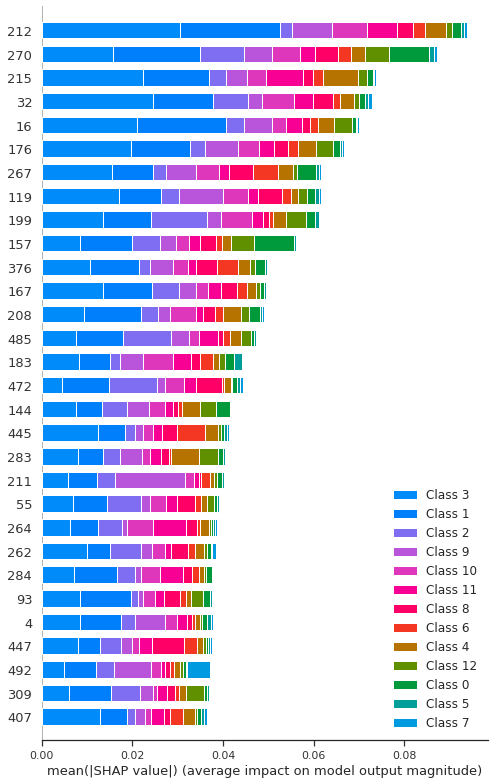

 * Initialising ...
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_36 (Batc (None, 32)                128       
_________________________________________________________________
activation_36 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_37 (Batc (None, 16)                64        
_________________________________________________________________
activation_37 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7672 - accuracy: 0.7274 - auc: 0.9770 - precision: 0.9586 - recall: 0.2938 - val_loss: 0.8439 - val_accuracy: 0.8600 - val_auc: 0.9908 - val_precision: 0.9756 - val_recall: 0.3474

Epoch 00019: val_loss improved from 0.88066 to 0.84390, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7438 - accuracy: 0.7421 - auc: 0.9794 - precision: 0.9507 - recall: 0.3217 - val_loss: 0.8654 - val_accuracy: 0.8310 - val_auc: 0.9891 - val_precision: 0.9593 - val_recall: 0.3416

Epoch 00020: val_loss did not improve from 0.84390
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.7633 - auc: 0.9818 - precision: 0.9503 - recall: 0.3643 - val_loss: 0.7636 - val_accuracy: 0.8724 - val_auc: 0.9922 - val_precision: 0.9677 - val_recall: 0.4133

Epoch 00021: val_loss improved from 0.84390 to 0.76358, saving model to weights/best_m


Epoch 00042: val_loss improved from 0.35869 to 0.35620, saving model to weights/best_model_annotation.h5
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2824 - accuracy: 0.8910 - auc: 0.9954 - precision: 0.9408 - recall: 0.8034 - val_loss: 0.3593 - val_accuracy: 0.9123 - val_auc: 0.9961 - val_precision: 0.9364 - val_recall: 0.8651

Epoch 00043: val_loss did not improve from 0.35620
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2779 - accuracy: 0.8923 - auc: 0.9955 - precision: 0.9405 - recall: 0.8108 - val_loss: 0.3414 - val_accuracy: 0.9173 - val_auc: 0.9964 - val_precision: 0.9401 - val_recall: 0.8767

Epoch 00044: val_loss improved from 0.35620 to 0.34138, saving model to weights/best_model_annotation.h5
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2617 - accuracy: 0.8964 - auc: 0.9960 - precision: 0.9452 - recall: 0.8232 - val_loss: 0.3776 - val_accuracy: 0.8970 - val_auc: 0.9957 - val_precisi

56/56 [==============================] - 0s 3ms/step - loss: 0.1338 - accuracy: 0.9373 - auc: 0.9983 - precision: 0.9578 - recall: 0.9100 - val_loss: 0.2163 - val_accuracy: 0.9420 - val_auc: 0.9972 - val_precision: 0.9496 - val_recall: 0.9297

Epoch 00067: val_loss improved from 0.22166 to 0.21630, saving model to weights/best_model_annotation.h5
Epoch 68/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1521 - accuracy: 0.9296 - auc: 0.9980 - precision: 0.9487 - recall: 0.9021 - val_loss: 0.2055 - val_accuracy: 0.9413 - val_auc: 0.9970 - val_precision: 0.9504 - val_recall: 0.9311

Epoch 00068: val_loss improved from 0.21630 to 0.20546, saving model to weights/best_model_annotation.h5
Epoch 69/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1449 - accuracy: 0.9360 - auc: 0.9984 - precision: 0.9562 - recall: 0.9111 - val_loss: 0.2320 - val_accuracy: 0.9318 - val_auc: 0.9965 - val_precision: 0.9426 - val_recall: 0.9173

Epoch 00069: val_loss did not im

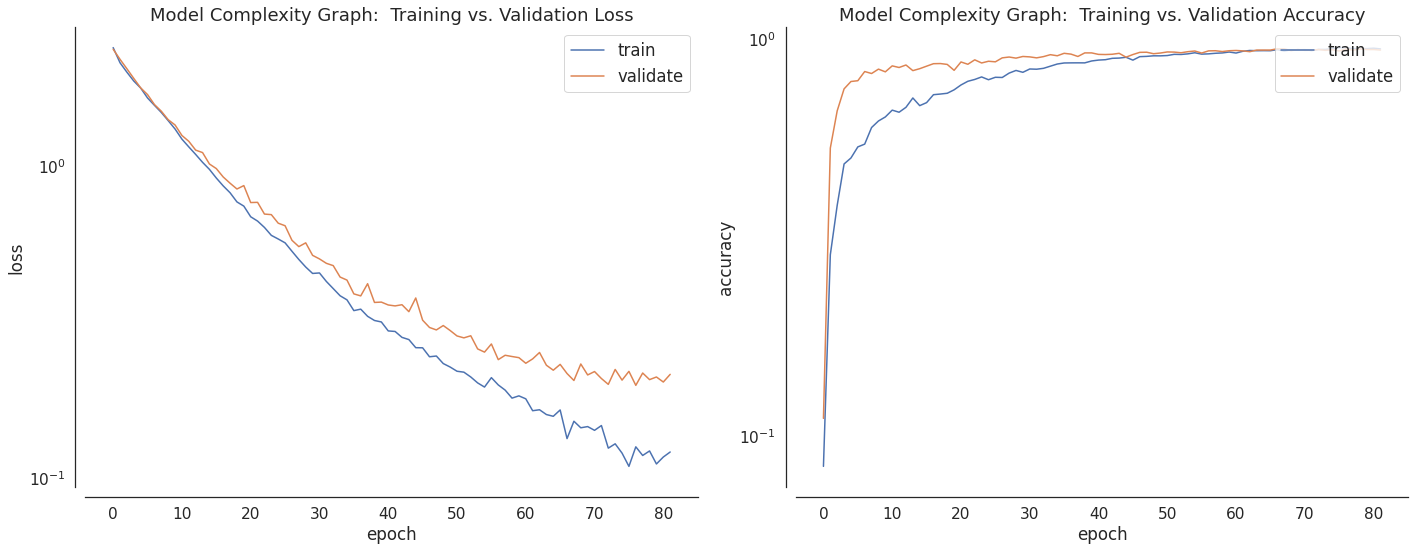

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

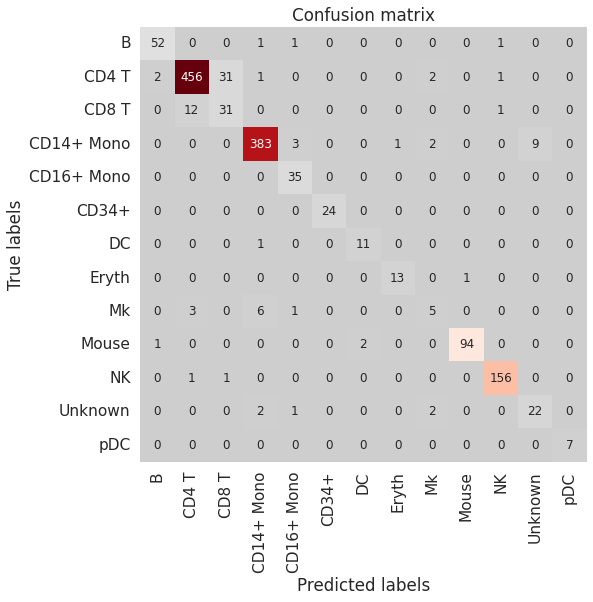

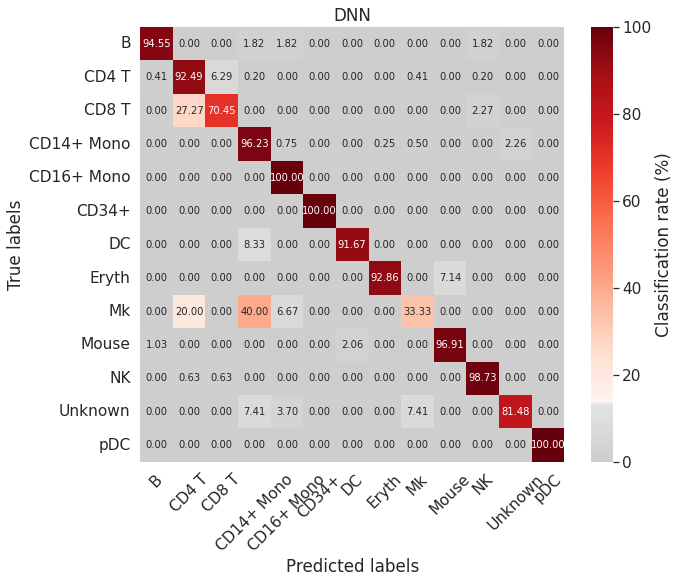

              precision    recall  f1-score   support

           B       0.95      0.95      0.95        55
       CD4 T       0.97      0.92      0.95       493
       CD8 T       0.49      0.70      0.58        44
  CD14+ Mono       0.97      0.96      0.97       398
  CD16+ Mono       0.85      1.00      0.92        35
       CD34+       1.00      1.00      1.00        24
          DC       0.85      0.92      0.88        12
       Eryth       0.93      0.93      0.93        14
          Mk       0.45      0.33      0.38        15
       Mouse       0.99      0.97      0.98        97
          NK       0.98      0.99      0.98       158
     Unknown       0.71      0.81      0.76        27
         pDC       1.00      1.00      1.00         7

    accuracy                           0.93      1379
   macro avg       0.86      0.88      0.87      1379
weighted avg       0.94      0.93      0.94      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.1982 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


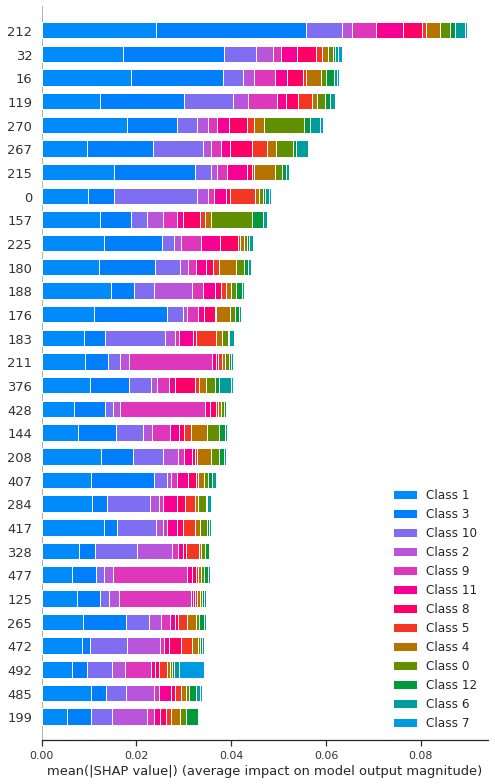

 * Initialising ...
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_40 (Batc (None, 32)                128       
_________________________________________________________________
activation_40 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_41 (Batc (None, 16)                64        
_________________________________________________________________
activation_41 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7641 - accuracy: 0.7349 - auc: 0.9787 - precision: 0.9519 - recall: 0.3089 - val_loss: 0.8417 - val_accuracy: 0.8666 - val_auc: 0.9914 - val_precision: 0.9709 - val_recall: 0.3387

Epoch 00019: val_loss improved from 0.85461 to 0.84166, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7297 - accuracy: 0.7570 - auc: 0.9805 - precision: 0.9515 - recall: 0.3346 - val_loss: 0.7740 - val_accuracy: 0.8738 - val_auc: 0.9925 - val_precision: 0.9581 - val_recall: 0.4148

Epoch 00020: val_loss improved from 0.84166 to 0.77402, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.7744 - auc: 0.9827 - precision: 0.9435 - recall: 0.3723 - val_loss: 0.7608 - val_accuracy: 0.8629 - val_auc: 0.9920 - val_precision: 0.9510 - val_recall: 0.4365

Epoch 00021: val_loss improved f


Epoch 00042: val_loss improved from 0.35910 to 0.34745, saving model to weights/best_model_annotation.h5
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2825 - accuracy: 0.8890 - auc: 0.9952 - precision: 0.9371 - recall: 0.8072 - val_loss: 0.3437 - val_accuracy: 0.9101 - val_auc: 0.9954 - val_precision: 0.9328 - val_recall: 0.8753

Epoch 00043: val_loss improved from 0.34745 to 0.34365, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2669 - accuracy: 0.8850 - auc: 0.9952 - precision: 0.9334 - recall: 0.8029 - val_loss: 0.3211 - val_accuracy: 0.9159 - val_auc: 0.9954 - val_precision: 0.9319 - val_recall: 0.8927

Epoch 00044: val_loss improved from 0.34365 to 0.32105, saving model to weights/best_model_annotation.h5
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2677 - accuracy: 0.8943 - auc: 0.9958 - precision: 0.9412 - recall: 0.8246 - val_loss: 0.3238 

56/56 [==============================] - 0s 3ms/step - loss: 0.1621 - accuracy: 0.9295 - auc: 0.9980 - precision: 0.9487 - recall: 0.8993 - val_loss: 0.2422 - val_accuracy: 0.9318 - val_auc: 0.9954 - val_precision: 0.9385 - val_recall: 0.9188

Epoch 00067: val_loss did not improve from 0.23166
Epoch 68/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1468 - accuracy: 0.9327 - auc: 0.9983 - precision: 0.9537 - recall: 0.9084 - val_loss: 0.2299 - val_accuracy: 0.9347 - val_auc: 0.9956 - val_precision: 0.9420 - val_recall: 0.9181

Epoch 00068: val_loss improved from 0.23166 to 0.22987, saving model to weights/best_model_annotation.h5
Epoch 69/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1478 - accuracy: 0.9195 - auc: 0.9973 - precision: 0.9416 - recall: 0.8923 - val_loss: 0.2511 - val_accuracy: 0.9282 - val_auc: 0.9953 - val_precision: 0.9364 - val_recall: 0.9181

Epoch 00069: val_loss did not improve from 0.22987
Epoch 70/100
56/56 [===============

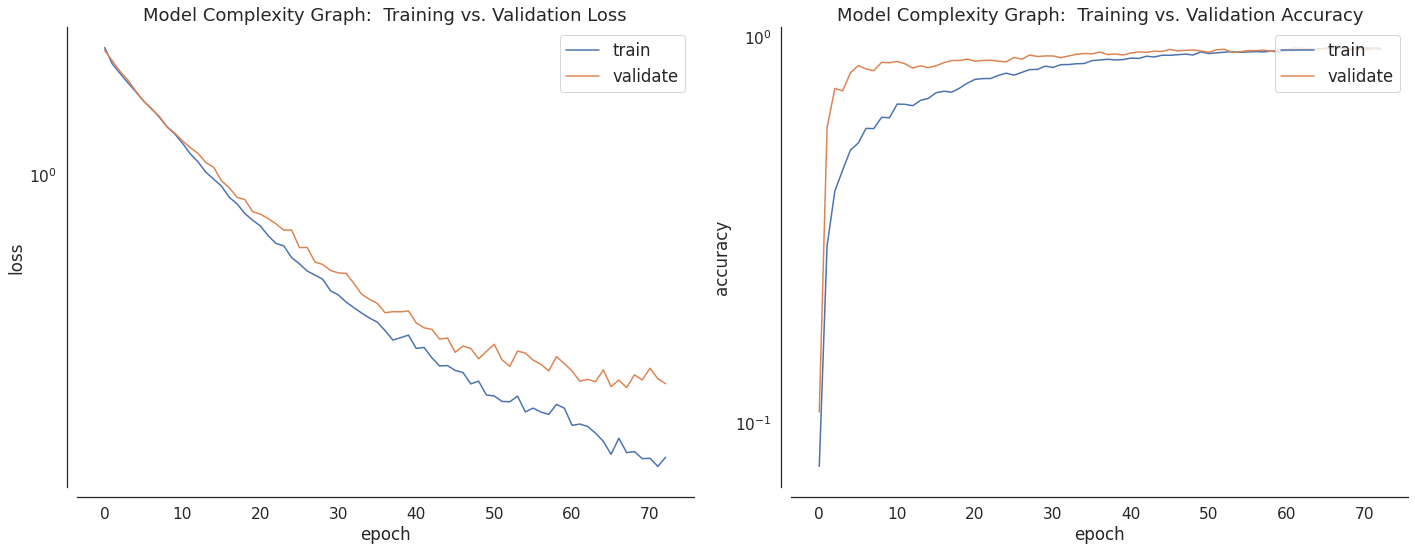

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

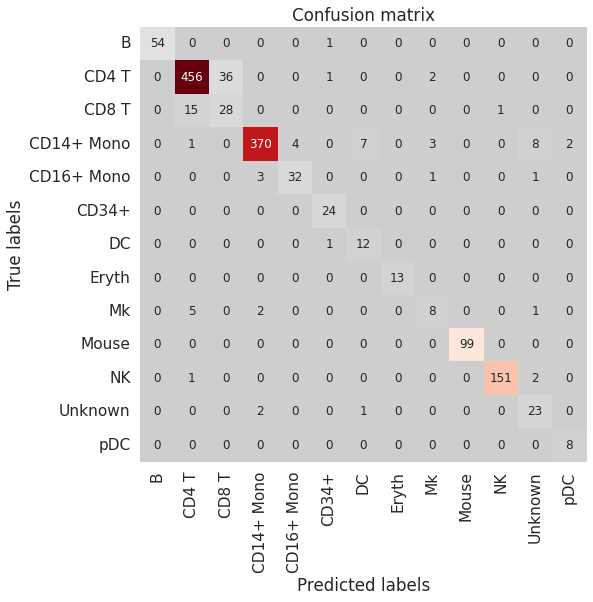

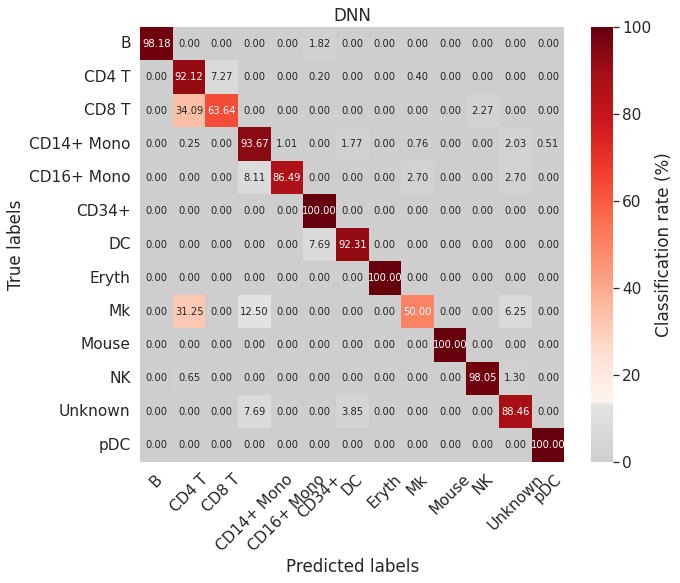

              precision    recall  f1-score   support

           B       1.00      0.98      0.99        55
       CD4 T       0.95      0.92      0.94       495
       CD8 T       0.44      0.64      0.52        44
  CD14+ Mono       0.98      0.94      0.96       395
  CD16+ Mono       0.89      0.86      0.88        37
       CD34+       0.89      1.00      0.94        24
          DC       0.60      0.92      0.73        13
       Eryth       1.00      1.00      1.00        13
          Mk       0.57      0.50      0.53        16
       Mouse       1.00      1.00      1.00        99
          NK       0.99      0.98      0.99       154
     Unknown       0.66      0.88      0.75        26
         pDC       0.80      1.00      0.89         8

    accuracy                           0.93      1379
   macro avg       0.83      0.89      0.85      1379
weighted avg       0.94      0.93      0.93      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2299 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


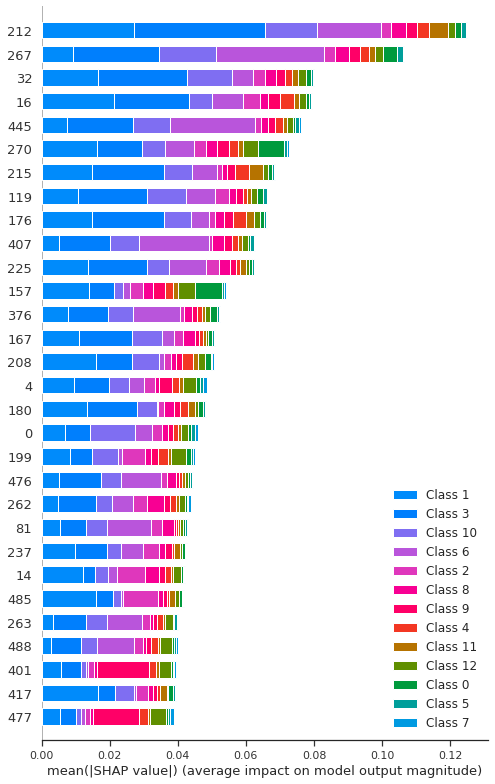

 * Initialising ...
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_44 (Batc (None, 32)                128       
_________________________________________________________________
activation_44 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_45 (Batc (None, 16)                64        
_________________________________________________________________
activation_45 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7687 - accuracy: 0.7390 - auc: 0.9788 - precision: 0.9514 - recall: 0.3123 - val_loss: 0.8357 - val_accuracy: 0.8484 - val_auc: 0.9913 - val_precision: 0.9663 - val_recall: 0.3539

Epoch 00019: val_loss improved from 0.86113 to 0.83566, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7293 - accuracy: 0.7452 - auc: 0.9798 - precision: 0.9409 - recall: 0.3379 - val_loss: 0.7850 - val_accuracy: 0.8658 - val_auc: 0.9924 - val_precision: 0.9704 - val_recall: 0.4046

Epoch 00020: val_loss improved from 0.83566 to 0.78504, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.7655 - auc: 0.9814 - precision: 0.9499 - recall: 0.3818 - val_loss: 0.7409 - val_accuracy: 0.8629 - val_auc: 0.9925 - val_precision: 0.9574 - val_recall: 0.4728

Epoch 00021: val_loss improved f

Epoch 42/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2915 - accuracy: 0.8885 - auc: 0.9956 - precision: 0.9338 - recall: 0.8029 - val_loss: 0.3151 - val_accuracy: 0.9181 - val_auc: 0.9970 - val_precision: 0.9424 - val_recall: 0.8898

Epoch 00042: val_loss improved from 0.31634 to 0.31512, saving model to weights/best_model_annotation.h5
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2694 - accuracy: 0.8865 - auc: 0.9956 - precision: 0.9312 - recall: 0.8081 - val_loss: 0.2883 - val_accuracy: 0.9282 - val_auc: 0.9974 - val_precision: 0.9446 - val_recall: 0.9028

Epoch 00043: val_loss improved from 0.31512 to 0.28825, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2738 - accuracy: 0.8959 - auc: 0.9959 - precision: 0.9398 - recall: 0.8214 - val_loss: 0.2950 - val_accuracy: 0.9231 - val_auc: 0.9972 - val_precision: 0.9398 - val_recall: 0.8941

Epoch 00044: val_lo

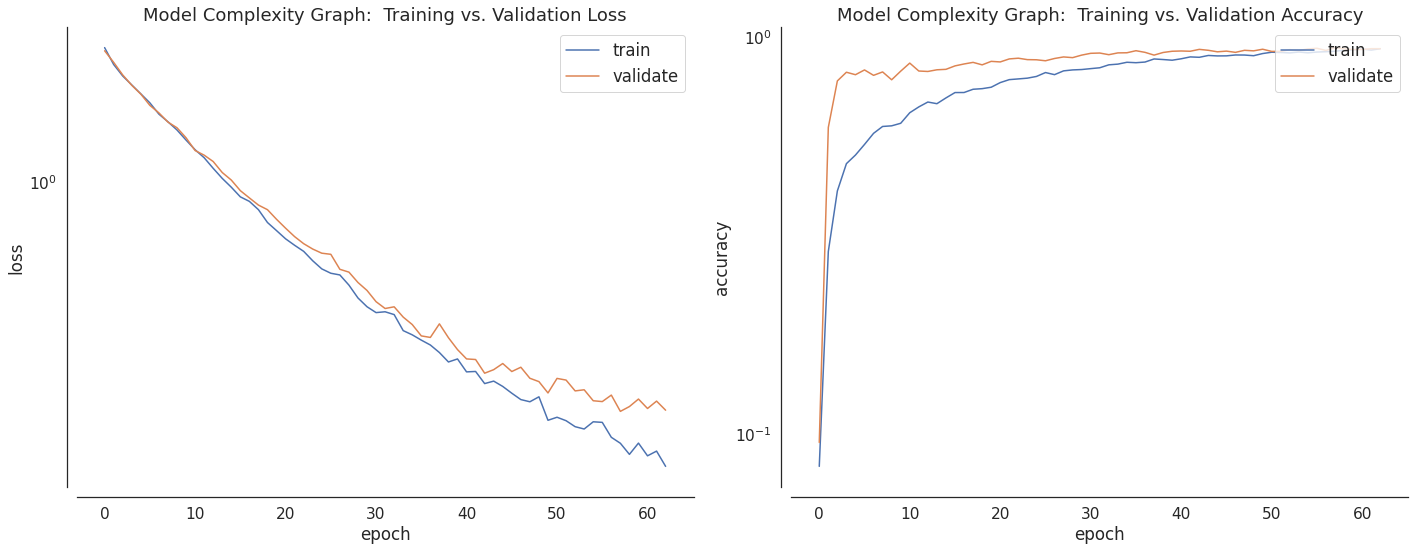

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

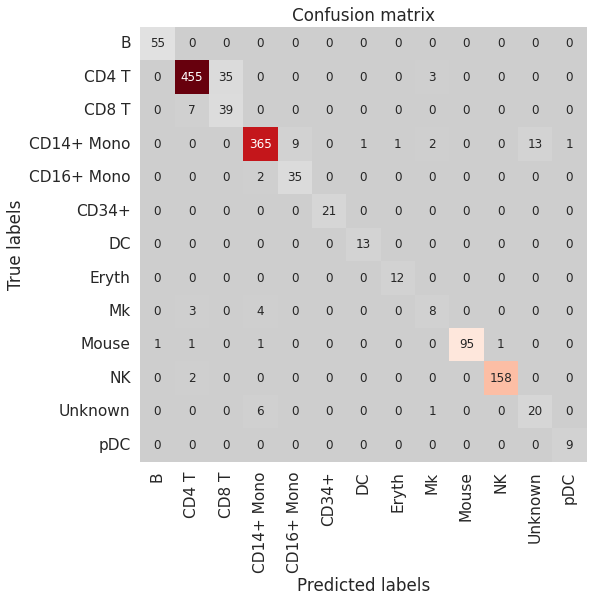

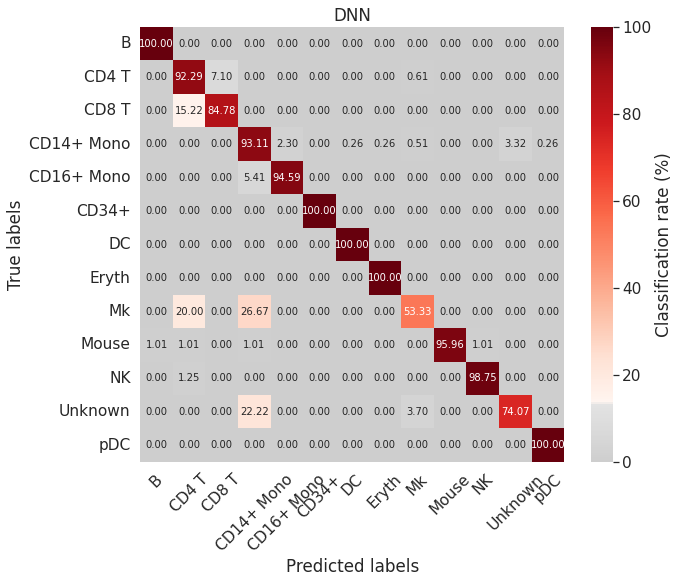

              precision    recall  f1-score   support

           B       0.98      1.00      0.99        55
       CD4 T       0.97      0.92      0.95       493
       CD8 T       0.53      0.85      0.65        46
  CD14+ Mono       0.97      0.93      0.95       392
  CD16+ Mono       0.80      0.95      0.86        37
       CD34+       1.00      1.00      1.00        21
          DC       0.93      1.00      0.96        13
       Eryth       0.92      1.00      0.96        12
          Mk       0.57      0.53      0.55        15
       Mouse       1.00      0.96      0.98        99
          NK       0.99      0.99      0.99       160
     Unknown       0.61      0.74      0.67        27
         pDC       0.90      1.00      0.95         9

    accuracy                           0.93      1379
   macro avg       0.86      0.91      0.88      1379
weighted avg       0.94      0.93      0.94      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2248 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


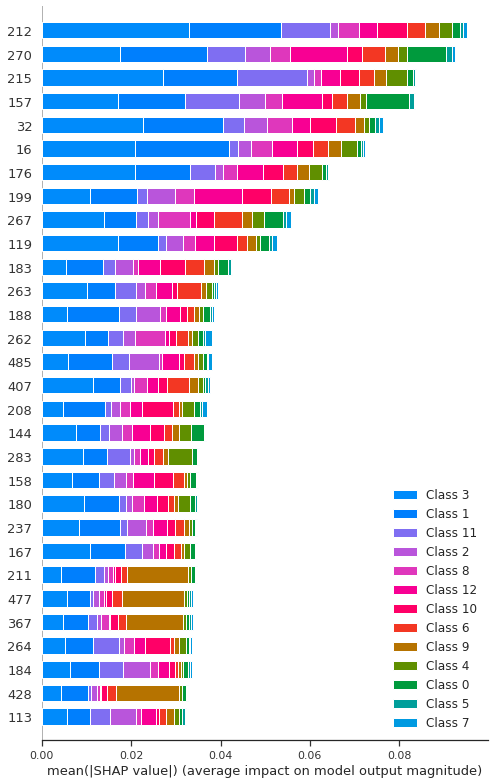

 * Initialising ...
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_48 (Batc (None, 32)                128       
_________________________________________________________________
activation_48 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_49 (Batc (None, 16)                64        
_________________________________________________________________
activation_49 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7872 - accuracy: 0.7320 - auc: 0.9770 - precision: 0.9507 - recall: 0.2905 - val_loss: 0.8407 - val_accuracy: 0.8622 - val_auc: 0.9919 - val_precision: 0.9833 - val_recall: 0.3423

Epoch 00019: val_loss improved from 0.95219 to 0.84073, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7561 - accuracy: 0.7383 - auc: 0.9779 - precision: 0.9404 - recall: 0.3206 - val_loss: 0.8255 - val_accuracy: 0.8513 - val_auc: 0.9913 - val_precision: 0.9770 - val_recall: 0.3691

Epoch 00020: val_loss improved from 0.84073 to 0.82552, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7248 - accuracy: 0.7595 - auc: 0.9813 - precision: 0.9497 - recall: 0.3593 - val_loss: 0.8115 - val_accuracy: 0.8310 - val_auc: 0.9903 - val_precision: 0.9532 - val_recall: 0.3836

Epoch 00021: val_loss improved f

56/56 [==============================] - 0s 3ms/step - loss: 0.3042 - accuracy: 0.8789 - auc: 0.9947 - precision: 0.9298 - recall: 0.7907 - val_loss: 0.3647 - val_accuracy: 0.8999 - val_auc: 0.9960 - val_precision: 0.9289 - val_recall: 0.8622

Epoch 00042: val_loss improved from 0.36666 to 0.36470, saving model to weights/best_model_annotation.h5
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2845 - accuracy: 0.8801 - auc: 0.9946 - precision: 0.9310 - recall: 0.7923 - val_loss: 0.3333 - val_accuracy: 0.9137 - val_auc: 0.9968 - val_precision: 0.9332 - val_recall: 0.8709

Epoch 00043: val_loss improved from 0.36470 to 0.33328, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2876 - accuracy: 0.8799 - auc: 0.9951 - precision: 0.9352 - recall: 0.7983 - val_loss: 0.3275 - val_accuracy: 0.9123 - val_auc: 0.9969 - val_precision: 0.9360 - val_recall: 0.8702

Epoch 00044: val_loss improved f

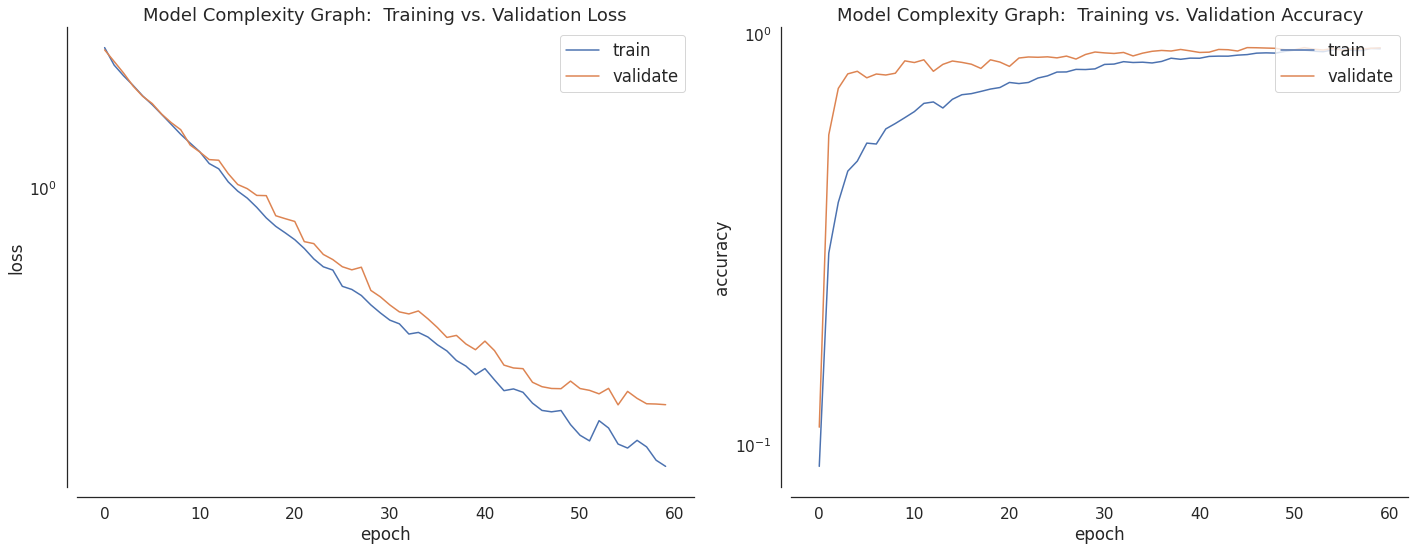

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

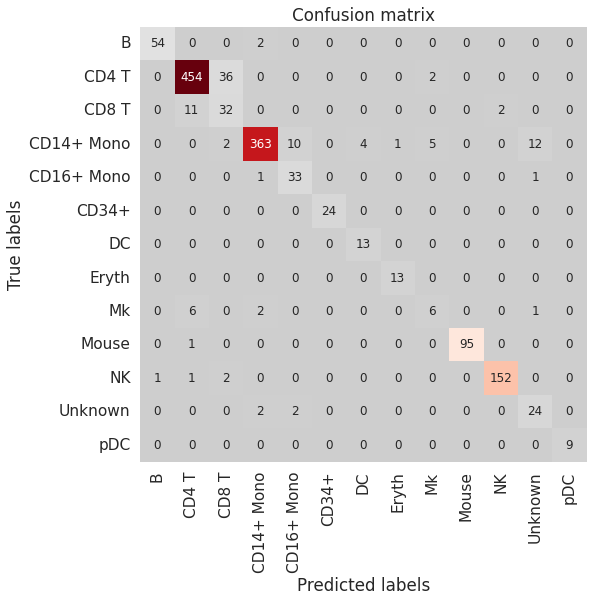

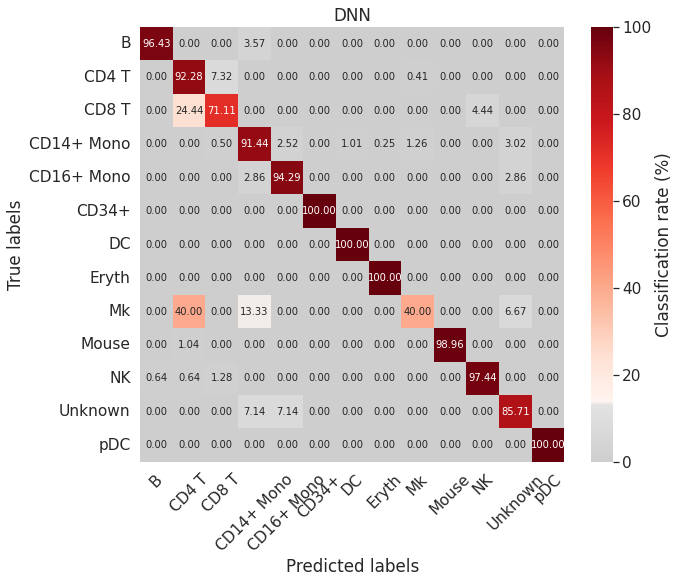

              precision    recall  f1-score   support

           B       0.98      0.96      0.97        56
       CD4 T       0.96      0.92      0.94       492
       CD8 T       0.44      0.71      0.55        45
  CD14+ Mono       0.98      0.91      0.95       397
  CD16+ Mono       0.73      0.94      0.83        35
       CD34+       1.00      1.00      1.00        24
          DC       0.76      1.00      0.87        13
       Eryth       0.93      1.00      0.96        13
          Mk       0.46      0.40      0.43        15
       Mouse       1.00      0.99      0.99        96
          NK       0.99      0.97      0.98       156
     Unknown       0.63      0.86      0.73        28
         pDC       1.00      1.00      1.00         9

    accuracy                           0.92      1379
   macro avg       0.84      0.90      0.86      1379
weighted avg       0.94      0.92      0.93      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2606 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


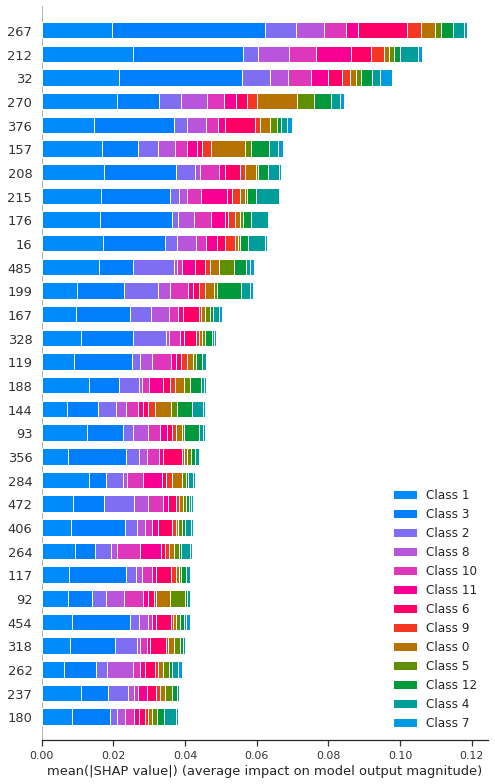

 * Initialising ...
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_52 (Batc (None, 32)                128       
_________________________________________________________________
activation_52 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_53 (Batc (None, 16)                64        
_________________________________________________________________
activation_53 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7766 - accuracy: 0.7508 - auc: 0.9799 - precision: 0.9553 - recall: 0.3177 - val_loss: 0.8303 - val_accuracy: 0.8753 - val_auc: 0.9929 - val_precision: 0.9838 - val_recall: 0.3532

Epoch 00019: val_loss improved from 0.86934 to 0.83031, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7434 - accuracy: 0.7563 - auc: 0.9801 - precision: 0.9484 - recall: 0.3469 - val_loss: 0.7719 - val_accuracy: 0.8760 - val_auc: 0.9933 - val_precision: 0.9783 - val_recall: 0.4249

Epoch 00020: val_loss improved from 0.83031 to 0.77187, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.7481 - auc: 0.9805 - precision: 0.9401 - recall: 0.3812 - val_loss: 0.7577 - val_accuracy: 0.8724 - val_auc: 0.9932 - val_precision: 0.9753 - val_recall: 0.4300

Epoch 00021: val_loss improved f


Epoch 00042: val_loss improved from 0.34806 to 0.33115, saving model to weights/best_model_annotation.h5
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2943 - accuracy: 0.8859 - auc: 0.9952 - precision: 0.9373 - recall: 0.8020 - val_loss: 0.3144 - val_accuracy: 0.9246 - val_auc: 0.9971 - val_precision: 0.9396 - val_recall: 0.8796

Epoch 00043: val_loss improved from 0.33115 to 0.31442, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2870 - accuracy: 0.8892 - auc: 0.9952 - precision: 0.9368 - recall: 0.8096 - val_loss: 0.3041 - val_accuracy: 0.9195 - val_auc: 0.9971 - val_precision: 0.9388 - val_recall: 0.8789

Epoch 00044: val_loss improved from 0.31442 to 0.30411, saving model to weights/best_model_annotation.h5
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2756 - accuracy: 0.8921 - auc: 0.9956 - precision: 0.9371 - recall: 0.8139 - val_loss: 0.3141 

56/56 [==============================] - 0s 3ms/step - loss: 0.1567 - accuracy: 0.9289 - auc: 0.9981 - precision: 0.9533 - recall: 0.8995 - val_loss: 0.2219 - val_accuracy: 0.9260 - val_auc: 0.9968 - val_precision: 0.9388 - val_recall: 0.9123

Epoch 00067: val_loss did not improve from 0.22015
Epoch 00067: early stopping


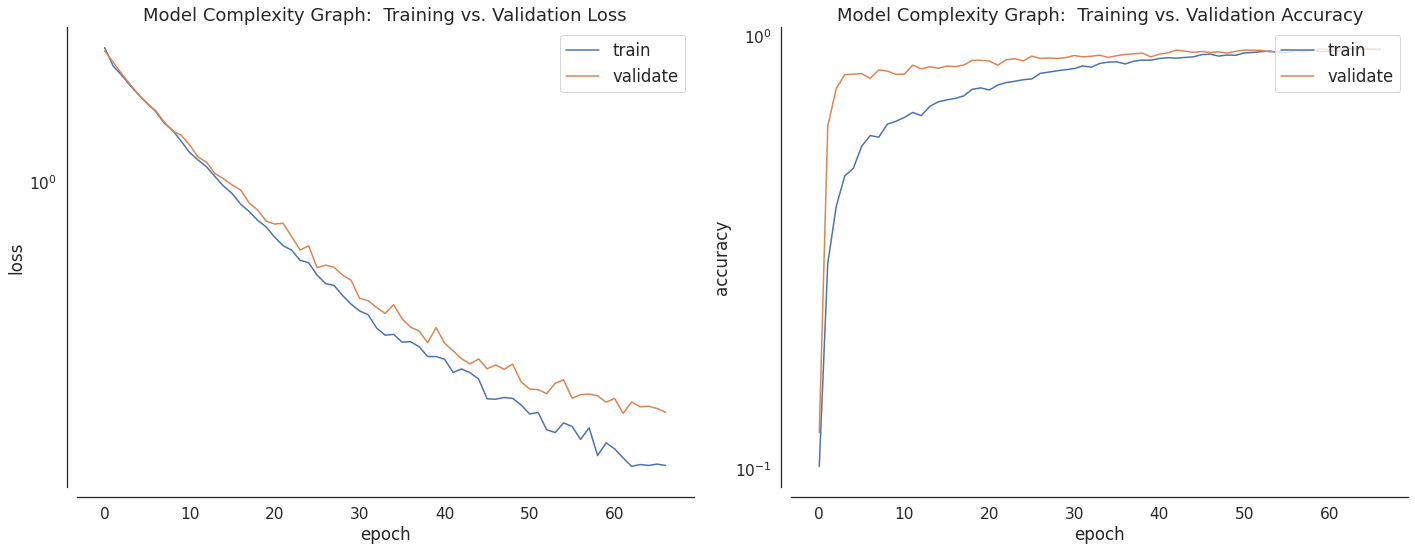

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

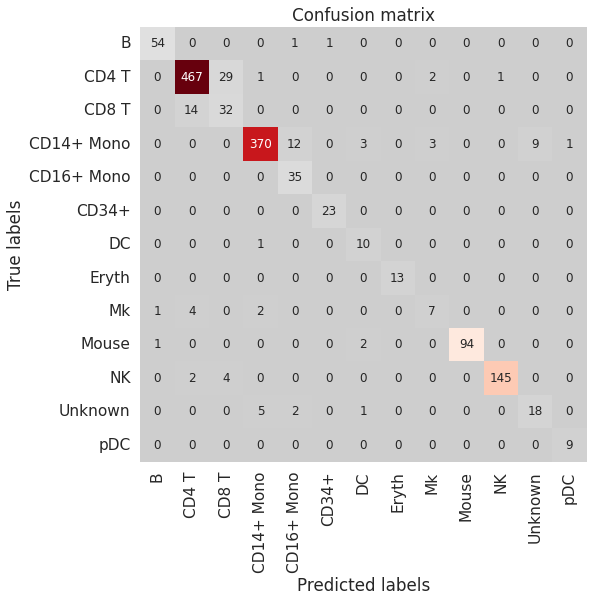

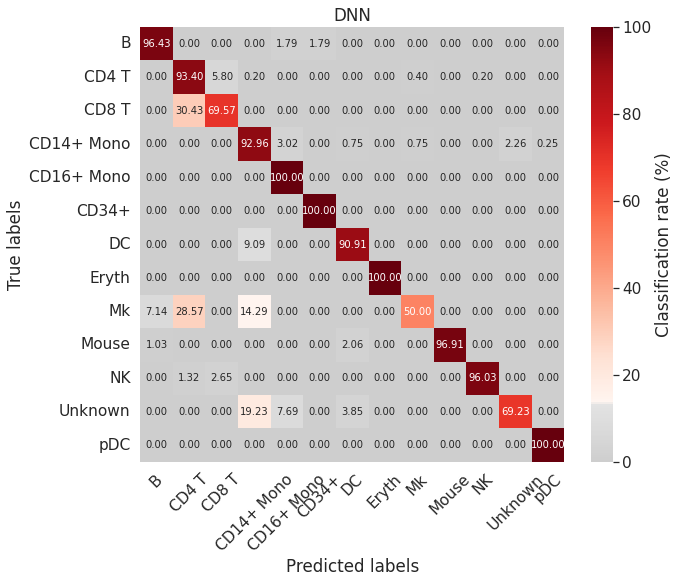

              precision    recall  f1-score   support

           B       0.96      0.96      0.96        56
       CD4 T       0.96      0.93      0.95       500
       CD8 T       0.49      0.70      0.58        46
  CD14+ Mono       0.98      0.93      0.95       398
  CD16+ Mono       0.70      1.00      0.82        35
       CD34+       0.96      1.00      0.98        23
          DC       0.62      0.91      0.74        11
       Eryth       1.00      1.00      1.00        13
          Mk       0.58      0.50      0.54        14
       Mouse       1.00      0.97      0.98        97
          NK       0.99      0.96      0.98       151
     Unknown       0.67      0.69      0.68        26
         pDC       0.90      1.00      0.95         9

    accuracy                           0.93      1379
   macro avg       0.83      0.89      0.85      1379
weighted avg       0.94      0.93      0.93      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2201 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


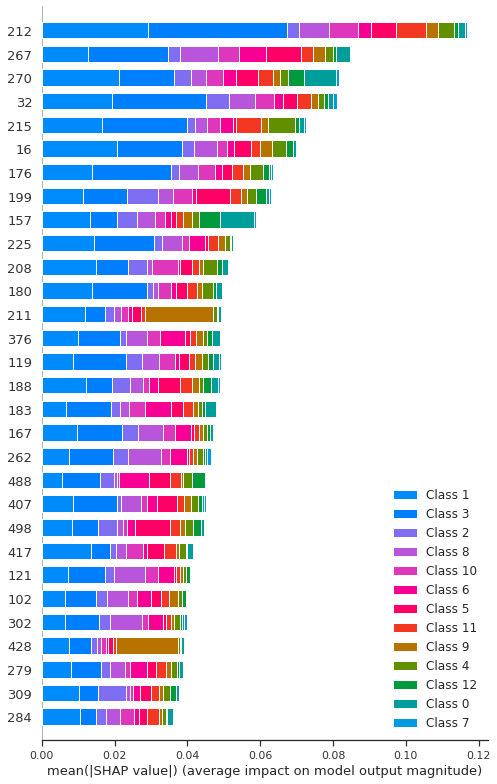

 * Initialising ...
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_56 (Batc (None, 32)                128       
_________________________________________________________________
activation_56 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_57 (Batc (None, 16)                64        
_________________________________________________________________
activation_57 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7758 - accuracy: 0.7310 - auc: 0.9782 - precision: 0.9560 - recall: 0.2914 - val_loss: 0.8632 - val_accuracy: 0.8390 - val_auc: 0.9898 - val_precision: 0.9586 - val_recall: 0.3191

Epoch 00019: val_loss improved from 0.90647 to 0.86319, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7702 - accuracy: 0.7374 - auc: 0.9795 - precision: 0.9418 - recall: 0.3228 - val_loss: 0.7859 - val_accuracy: 0.8666 - val_auc: 0.9920 - val_precision: 0.9576 - val_recall: 0.3930

Epoch 00020: val_loss improved from 0.86319 to 0.78586, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7096 - accuracy: 0.7555 - auc: 0.9814 - precision: 0.9386 - recall: 0.3634 - val_loss: 0.8021 - val_accuracy: 0.8412 - val_auc: 0.9899 - val_precision: 0.9324 - val_recall: 0.4003

Epoch 00021: val_loss did not im

56/56 [==============================] - 0s 3ms/step - loss: 0.2913 - accuracy: 0.8848 - auc: 0.9949 - precision: 0.9359 - recall: 0.7943 - val_loss: 0.3687 - val_accuracy: 0.9079 - val_auc: 0.9955 - val_precision: 0.9308 - val_recall: 0.8492

Epoch 00043: val_loss did not improve from 0.34245
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2684 - accuracy: 0.8892 - auc: 0.9956 - precision: 0.9420 - recall: 0.8127 - val_loss: 0.3462 - val_accuracy: 0.9166 - val_auc: 0.9955 - val_precision: 0.9307 - val_recall: 0.8673

Epoch 00044: val_loss did not improve from 0.34245
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2912 - accuracy: 0.8850 - auc: 0.9952 - precision: 0.9319 - recall: 0.8020 - val_loss: 0.3297 - val_accuracy: 0.9152 - val_auc: 0.9958 - val_precision: 0.9324 - val_recall: 0.8803

Epoch 00045: val_loss improved from 0.34245 to 0.32973, saving model to weights/best_model_annotation.h5
Epoch 46/100
56/56 [===============

56/56 [==============================] - 0s 3ms/step - loss: 0.1539 - accuracy: 0.9249 - auc: 0.9977 - precision: 0.9484 - recall: 0.8941 - val_loss: 0.2255 - val_accuracy: 0.9268 - val_auc: 0.9968 - val_precision: 0.9341 - val_recall: 0.9144

Epoch 00068: val_loss improved from 0.22628 to 0.22549, saving model to weights/best_model_annotation.h5
Epoch 69/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1484 - accuracy: 0.9338 - auc: 0.9980 - precision: 0.9544 - recall: 0.9037 - val_loss: 0.2271 - val_accuracy: 0.9275 - val_auc: 0.9967 - val_precision: 0.9362 - val_recall: 0.9159

Epoch 00069: val_loss did not improve from 0.22549
Epoch 70/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.9360 - auc: 0.9983 - precision: 0.9567 - recall: 0.9104 - val_loss: 0.2225 - val_accuracy: 0.9311 - val_auc: 0.9968 - val_precision: 0.9407 - val_recall: 0.9202

Epoch 00070: val_loss improved from 0.22549 to 0.22252, saving model to weights/best_m

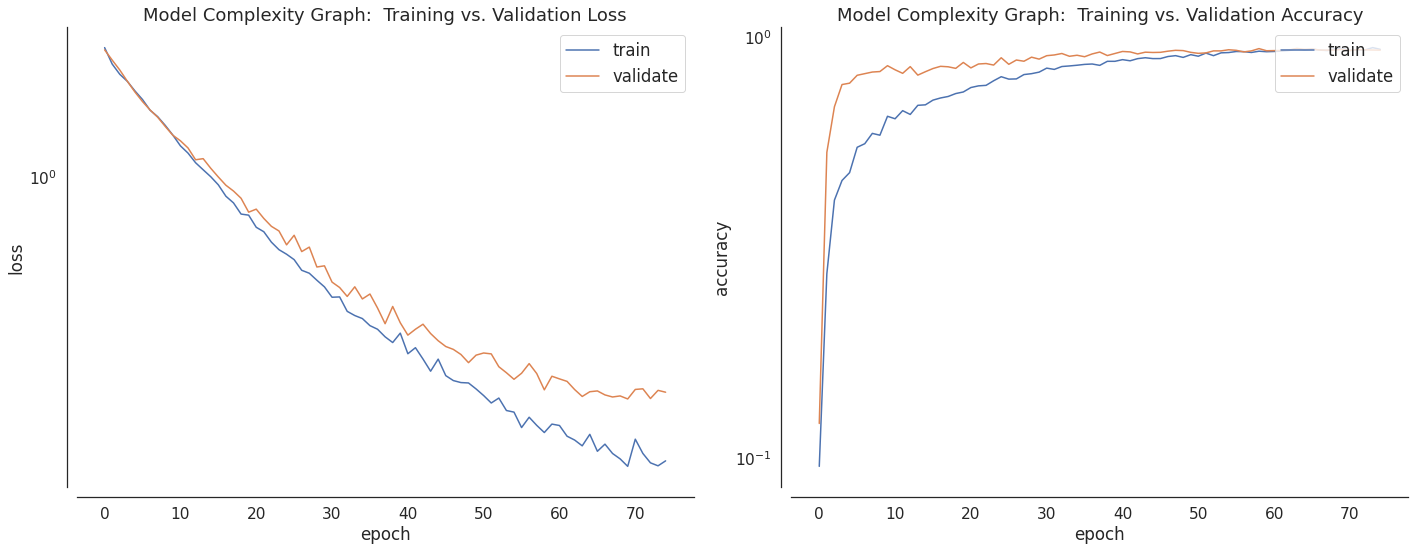

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

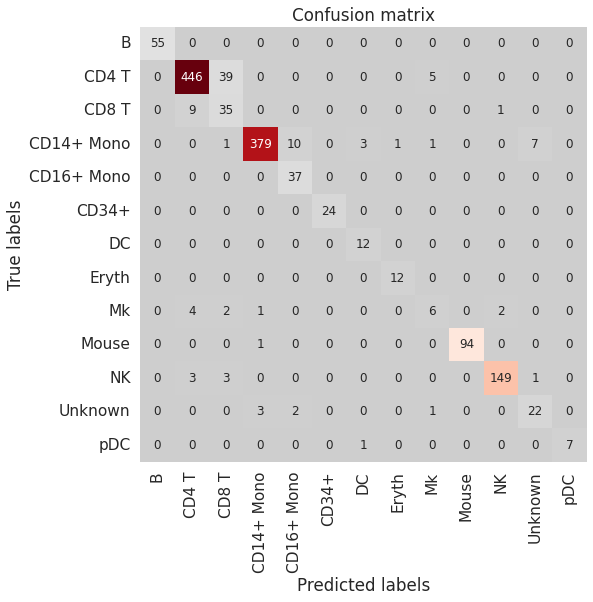

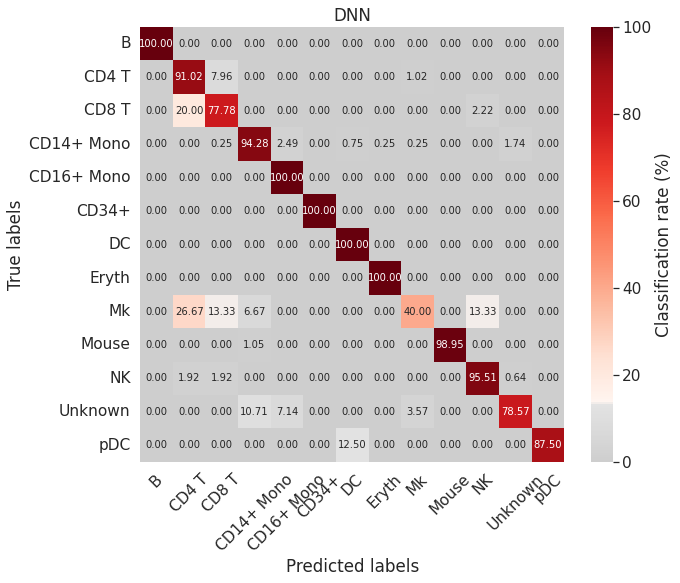

              precision    recall  f1-score   support

           B       1.00      1.00      1.00        55
       CD4 T       0.97      0.91      0.94       490
       CD8 T       0.44      0.78      0.56        45
  CD14+ Mono       0.99      0.94      0.96       402
  CD16+ Mono       0.76      1.00      0.86        37
       CD34+       1.00      1.00      1.00        24
          DC       0.75      1.00      0.86        12
       Eryth       0.92      1.00      0.96        12
          Mk       0.46      0.40      0.43        15
       Mouse       1.00      0.99      0.99        95
          NK       0.98      0.96      0.97       156
     Unknown       0.73      0.79      0.76        28
         pDC       1.00      0.88      0.93         8

    accuracy                           0.93      1379
   macro avg       0.85      0.90      0.86      1379
weighted avg       0.94      0.93      0.93      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2225 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


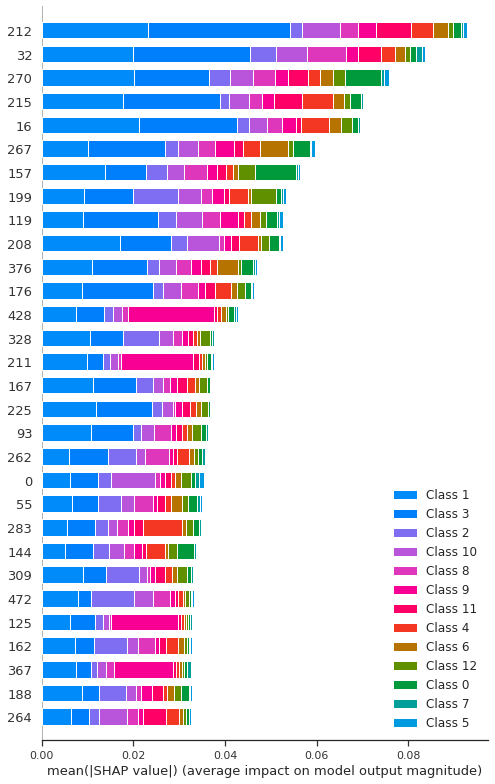

CPU times: user 13min 35s, sys: 26.9 s, total: 14min 2s
Wall time: 6min 52s


In [18]:
%%time
k = 50
for tryy in range(1,num_times+1):
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(train_X_y, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(train_X_y, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers)

In [19]:
# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
np.random.seed(possible_seeds[seed_index])
seed_index += 1

## Train RankCorr

In [20]:
lamb_range = [0.5, 1.5, 3, 7, 21.9]
lamb_i = 0

In [21]:
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = lamb_range[lamb_i]
    lamb_i = lamb_i + 1

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        print(lamb)
        print(len(rankcorr_markers))
        print(k)
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        #print("Excess Length of markers")
        #print(len(rankcorr_markers))
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(citeseq_adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'rankcorr_markers_k_{}.npy'.format(k), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_k_{}.png'.format(k), markers = rankcorr_markers)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [22]:
k = 50
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = 3.2# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        #print("Excess Length of markers")
        #print(len(rankcorr_markers))
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(citeseq_adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers)

## Train L1 VAE

In [23]:
feature_std = torch.tensor(X).std(dim = 0)
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'l1_vae_markers_k_{}.npy'.format(k), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_k_{}.png'.format(k), markers = l1_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 63.47it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 63.40it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

In [24]:
feature_std = torch.tensor(X).std(dim = 0)
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 66.15it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 64.27it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` inst

## Train Global Gate

In [25]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'globalgate_vae_markers_k_{}.npy'.format(k), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_k_{}.png'.format(k), markers = globalgate_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 53.24it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

In [26]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 38.12it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 38.72it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

## Train MarkerMap Unsupervised

In [27]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    marker_map_unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = marker_map_unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_k_{}.npy'.format(k), marker_map_unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_k_{}.png'.format(k), markers = marker_map_unsupervised_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 48.42it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

In [28]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Marker Map Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_{}.png'.format(tryy), markers = unsupervised_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 35.60it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 35.09it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

## MarkerMap Supervised

In [29]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'marker_map_supervised_markers_k_{}.npy'.format(k), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_k_{}.png'.format(k), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 52.96it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 44.51it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

In [30]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 37.62it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 37.91it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

## Train MarkerMap Mixed Supervision

In [31]:
for tryy in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
    tmp_path = model_save_path + 'marker_map_mixed_k_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_mixed_markers_k_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_k_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_k_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 33.07it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 32.17it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

In [32]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
    tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_mixed_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 34.41it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 34.65it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

## Concrete VAE

In [33]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_k_{}.ckpt'.format(k)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'concrete_vae_markers_k_{}.npy'.format(k), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_k_{}.png'.format(k), markers = concrete_vae_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 58.05it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

In [34]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 61.96it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

## LassoNet

In [36]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [37]:
from functools import partial
from lassonet import plot_path

In [38]:
k = 50
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, hidden_layer_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

In [39]:
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, hidden_layer_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'lasso_net_markers_k_{}.npy'.format(k), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))
    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_k_{}.png'.format(k), markers = lasso_net_markers)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or

## Get Model Metrics from KNNs Classifiers


In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

In [25]:
def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [26]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/all_markers_indices_{}.npy',
                                  model_save_path+'all_markers_{}.npy',
                                  model_save_path+'all_markers_knn_results_{}.npy')

In [27]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [28]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

In [29]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

In [30]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

In [31]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')

In [32]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [33]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_{}.npy')

In [34]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_{}.npy')

In [35]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [36]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

### Generate the same metrics using the various K ranges instead

In [37]:
# for looking at things that did one trial
def batch_generate_metrics_from_saved_files_limited(X, y, format_folds_path, format_markers_path, format_save_path):
    for k in k_range:
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(k), format_markers_path.format(k), classifier_model, format_save_path.format(k))
    return

In [38]:
batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_k_{}.npy',
                                  model_save_path+'l1_vae_markers_k_{}.npy',
                                  model_save_path+'l1_vae_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_k_{}.npy',
                                  model_save_path+'smash_rf_markers_k_{}.npy',
                                  model_save_path+'smash_rf_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_k_{}.npy',
                                  model_save_path+'smash_markers_k_{}.npy',
                                  model_save_path+'smash_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_k_{}.npy',
                                  model_save_path+'rankcorr_markers_k_{}.npy',
                                  model_save_path+'rankcorr_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_k_{}.npy',
                                  model_save_path+'globalgate_vae_markers_k_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_k_{}.npy')


batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_k_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_k_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_k_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_k_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_k_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_k_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_k_{}.npy')


batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_k_{}.npy',
                                  model_save_path+'concrete_vae_markers_k_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_k_{}.npy',
                                  model_save_path+'lasso_net_markers_k_{}.npy',
                                  model_save_path+'lasso_net_knn_results_k_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

# Results and Visualizations

In [39]:
k = 50

## Accuracies and F1

In [40]:
result_axis = [
 ('All Markers', 'all_markers_results_{}.npy', 'all_markers_knn_results_{}.npy'), 
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('MarkerMap Unsupervised', 'marker_map_unsupervised_results_{}.npy', 'marker_map_unsupervised_knn_results_{}.npy'),
 ('MarkerMap Supervised', 'marker_map_supervised_results_{}.npy', 'marker_map_supervised_knn_results_{}.npy'),
 ('MarkerMap Mixed Supervision', 'marker_map_mixed_results_{}.npy', 'marker_map_mixed_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [41]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [42]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.075522          0.901260   
L1 VAE                                     0.131845          0.830028   
Smash RF                                   0.064327          0.919414   
SMaSH DNN                                  0.066705          0.917407   
RankCorr                                   0.071810          0.908663   
Global Gate VAE                            0.132077          0.830201   
MarkerMap Unsupervised                     0.090777          0.885232   
MarkerMap Supervised                       0.062529          0.923908   
MarkerMap Mixed Supervision                0.064907          0.919945   
Concrete VAE                               0.126740          0.836498   
LassoNet                                   0.061717          0.923947   

                             Misclassification Standard Deviation  \
All Markers                                              0.006872   
L1 VAE                                                   0.022164   
Smash RF                                                 0.003213   
SMaSH DNN                                                0.006878   
RankCorr                                                 0.007027   
Global Gate VAE                                          0.023406   
MarkerMap Unsupervised                                   0.013661   
MarkerMap Supervised                                     0.005747   
MarkerMap Mixed Supervision                              0.004615   
Concrete VAE                                             0.017066   
LassoNet                                                 0.007748   

                             Weighted F1 Standard Deviation  
All Markers                                        0.010136  
L1 VAE                                             0.029417  
Smash RF                                           0.005560  
SMaSH DNN                                          0.010106  
RankCorr                                           0.009918  
Global Gate VAE                                    0.028250  
MarkerMap Unsupervised                             0.018456  
MarkerMap Supervised                               0.007688  
MarkerMap Mixed Supervision                        0.006506  
Concrete VAE                                       0.022632  
LassoNet                                           0.010735

In [43]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [44]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.098376          0.897540   
L1 VAE                                     0.191241          0.781854   
Smash RF                                   0.066415          0.922119   
SMaSH DNN                                  0.066995          0.922880   
RankCorr                                   0.078074          0.906826   
Global Gate VAE                            0.179582          0.795818   
MarkerMap Unsupervised                     0.104408          0.884986   
MarkerMap Supervised                       0.061601          0.929458   
MarkerMap Mixed Supervision                0.070128          0.919698   
Concrete VAE                               0.179988          0.795338   
LassoNet                                   0.063573          0.926038   

                             Misclassification Standard Deviation  \
All Markers                                              0.005399   
L1 VAE                                                   0.035481   
Smash RF                                                 0.004450   
SMaSH DNN                                                0.006135   
RankCorr                                                 0.006291   
Global Gate VAE                                          0.028446   
MarkerMap Unsupervised                                   0.016218   
MarkerMap Supervised                                     0.004181   
MarkerMap Mixed Supervision                              0.004939   
Concrete VAE                                             0.023597   
LassoNet                                                 0.005267   

                             Weighted F1 Standard Deviation  
All Markers                                        0.005170  
L1 VAE                                             0.041716  
Smash RF                                           0.005374  
SMaSH DNN                                          0.007172  
RankCorr                                           0.008343  
Global Gate VAE                                    0.031686  
MarkerMap Unsupervised                             0.017210  
MarkerMap Supervised                               0.005023  
MarkerMap Mixed Supervision                        0.006366  
Concrete VAE                                       0.028182  
LassoNet                                           0.007348

## Confusion Matrices

k = 50

### All Markers

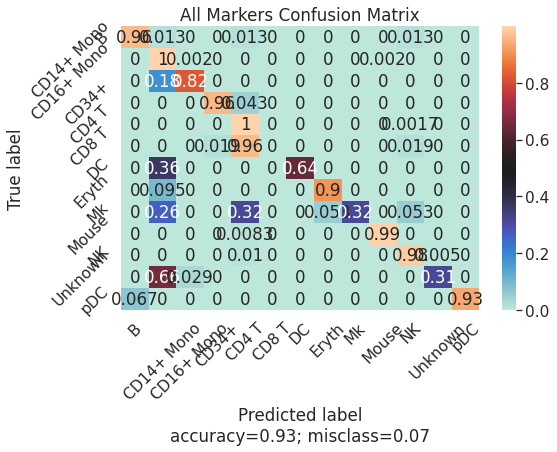

In [45]:
results =  np.load(model_save_path + 'all_markers_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'All Markers Confusion Matrix', save_path = viz_save_path + 'all_markers_cm.pdf', cmap = 'icefire')

### Smash RF

In [46]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

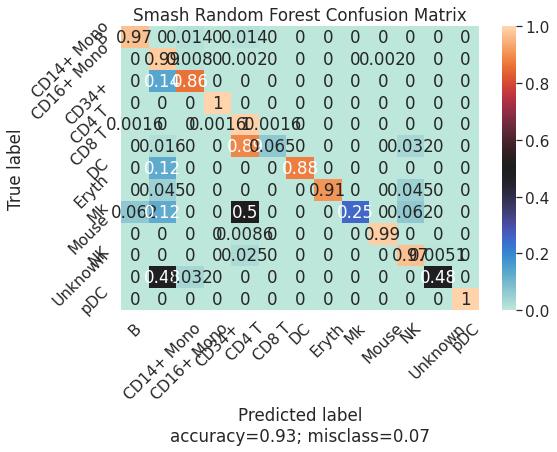

In [47]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.pdf', cmap = 'icefire')

### Smash DNN

In [48]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)

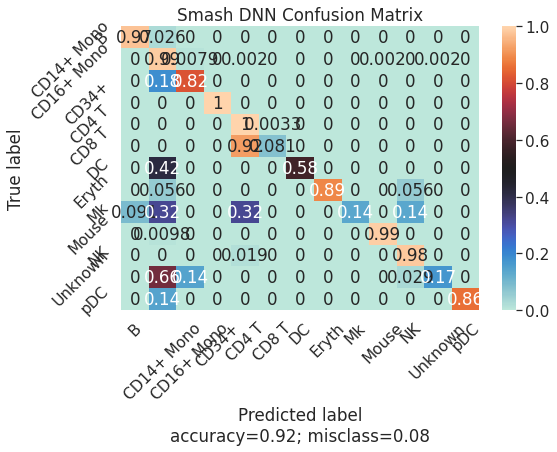

In [49]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.pdf', cmap = 'icefire')

### RankCorr

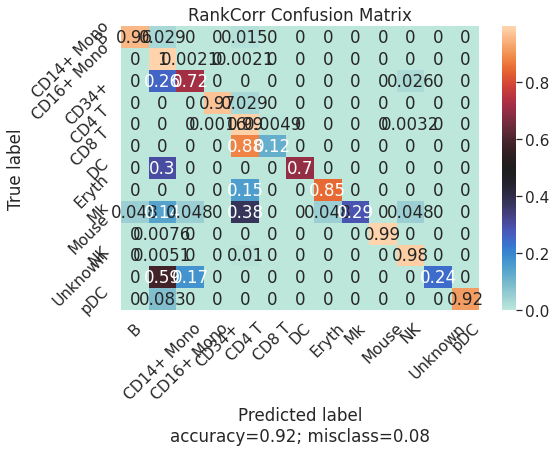

In [50]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.pdf', cmap = 'icefire')

### L1 VAE

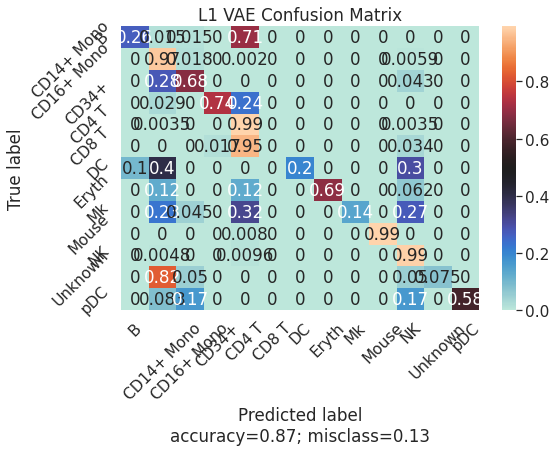

In [51]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.pdf', cmap = 'icefire')

### Global Gate VAE

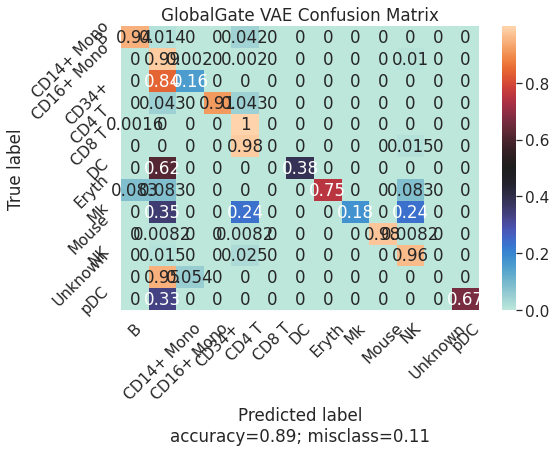

In [52]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.pdf', cmap = 'icefire')

### Running MarkerMap Unsupervised

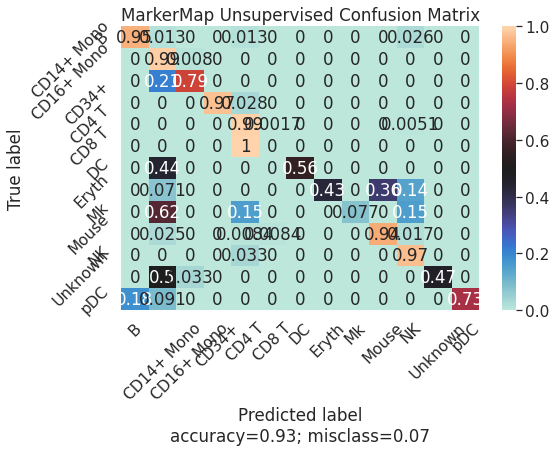

In [53]:
results =  np.load(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Unsupervised Confusion Matrix', save_path = viz_save_path + 'marker_map_unsupervised_cm.pdf', cmap = 'icefire')

### Running MarkerMap Supervised


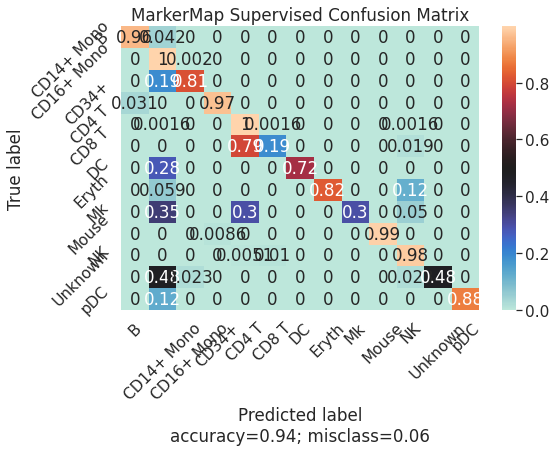

In [54]:
results =  np.load(model_save_path + 'marker_map_supervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Supervised Confusion Matrix', save_path = viz_save_path + 'marker_map_supervised_cm.pdf', cmap = 'icefire')

### MarkerMap Mixed Supervision

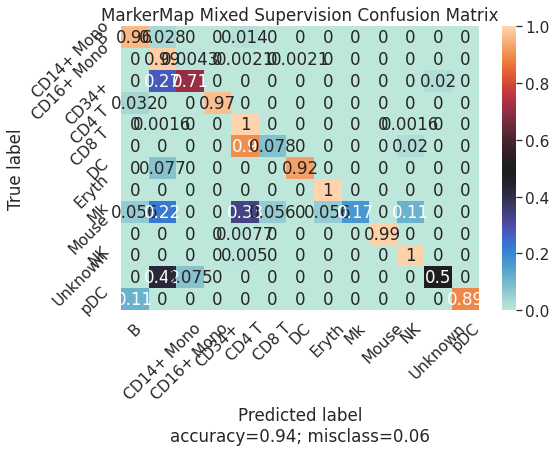

In [55]:
results =  np.load(model_save_path + 'marker_map_mixed_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Mixed Supervision Confusion Matrix', save_path = viz_save_path + 'marker_map_mixed_cm.pdf', cmap = 'icefire')

### Concrete VAE

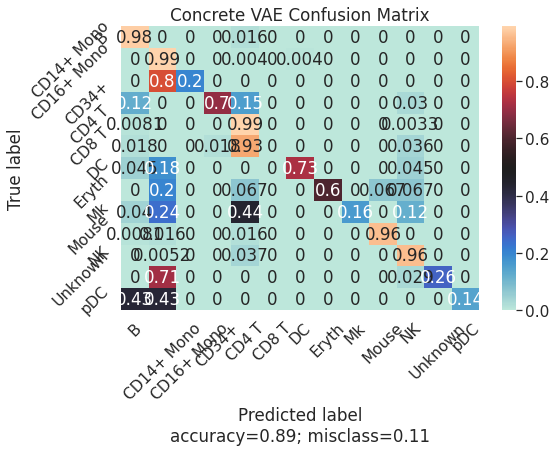

In [56]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.pdf', cmap = 'icefire')

## LassoNet

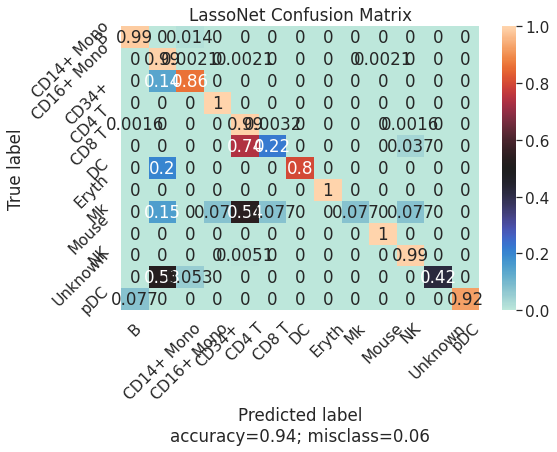

In [57]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.pdf', cmap = 'icefire')

## Visualizing k on weighted f1

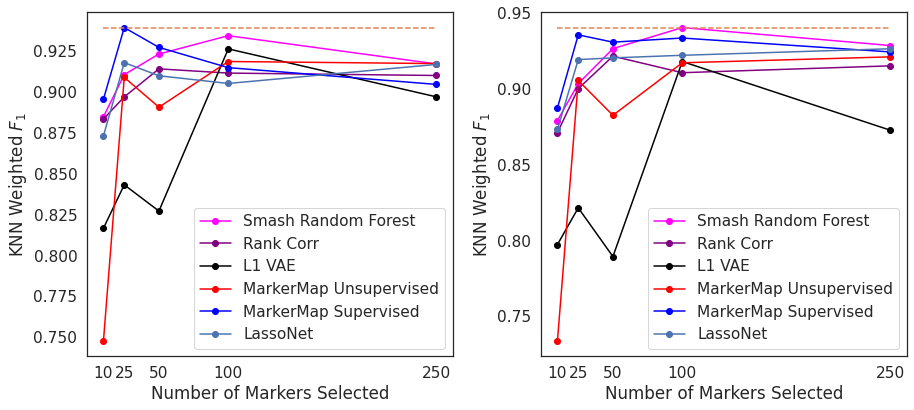

In [58]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))

#rf
smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel(r"KNN Weighted $F_1$")
axs[0].legend()

#knn

smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])


scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel(r"KNN Weighted $F_1$")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_weighted_f1_vs_k.pdf')

#### Include everything

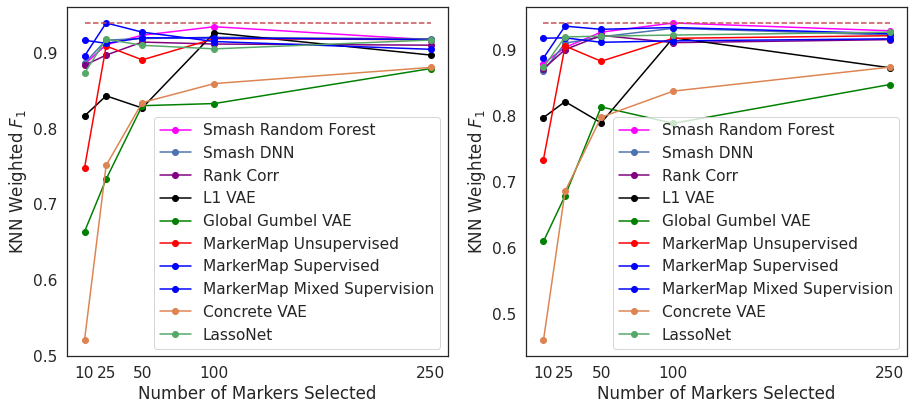

In [59]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))

#rf
smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[0].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[0].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[0].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[0].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel(r"KNN Weighted $F_1$")
axs[0].legend()

#knn

smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])


scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[1].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[1].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[1].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[1].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel(r"KNN Weighted $F_1$")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_weighted_f1_vs_k_all.pdf')

### Do Misclassification now

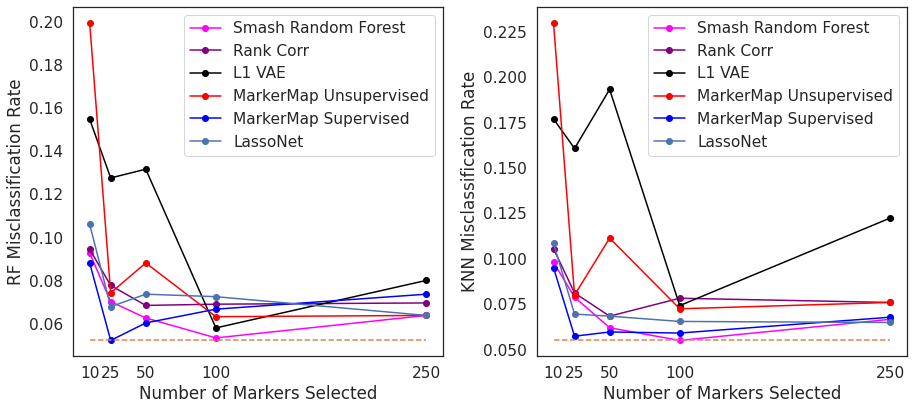

In [60]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))
# random forest
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)
    
scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel("RF Misclassification Rate")
axs[0].legend()

# knn
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel("KNN Misclassification Rate")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_misclassification_vs_k.pdf')

##### Include everything

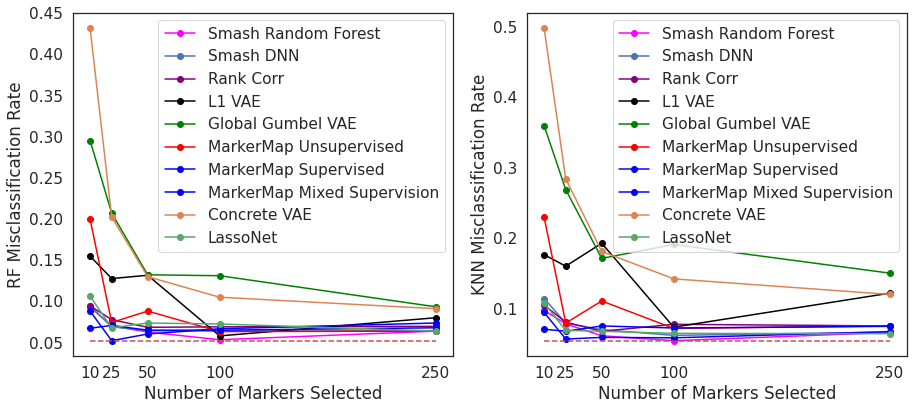

In [61]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))
# random forest
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)
    
scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[0].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[0].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[0].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[0].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel("RF Misclassification Rate")
axs[0].legend()

# knn
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[1].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[1].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[1].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[1].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel("KNN Misclassification Rate")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_misclassification_vs_k_all.pdf')

## Visualize Marker Selection

### Smash RF

In [62]:
smash_rf_markers = {}
smash_rf_f1 = {}

In [63]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/smash_rf_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'smash_rf_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    smash_rf_markers[k] = marker_data
    smash_rf_f1[k] = weighted_f1_score

### Smash DNN

In [64]:
smash_dnn_markers = {}
smash_dnn_f1 = {}

In [65]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/smash_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'smash_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    smash_dnn_markers[k] = marker_data
    smash_dnn_f1[k] = weighted_f1_score

### RankCorr

In [66]:
rankcorr_markers ={}
rankcorr_f1 = {}

In [67]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/rankcorr_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'rankcorr_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    rankcorr_markers[k] = marker_data
    rankcorr_f1[k] = weighted_f1_score

### L1 VAE

In [68]:
l1_vae_markers = {}
l1_vae_f1 = {}

In [69]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/l1_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    X_train = X[train_indices, :]
    feature_std = np.apply_along_axis(np.std, 0, X_train)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']

    model = load_model(VAE_l1_diag, model_save_path + 'l1_vae_k_{}.ckpt'.format(k))
    with torch.no_grad():
        markers = model.markers(feature_std, k)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    l1_vae_markers[k] = marker_data
    l1_vae_f1[k] = weighted_f1_score

### GlobalGate VAE

In [70]:
globalgate_vae_markers = {}
globalgate_vae_f1 = {}

In [71]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/globalgate_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'globalgate_vae_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    globalgate_vae_markers[k] = marker_data
    globalgate_vae_f1[k] = weighted_f1_score

### MarkerMap Unsupervised

In [72]:
marker_map_unsupervised_markers = {}
marker_map_unsupervised_f1 = {}

In [73]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'marker_map_unsupervised_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    marker_map_unsupervised_markers[k] = marker_data
    marker_map_unsupervised_f1[k] = weighted_f1_score

### RunningState Classifier

In [74]:
marker_map_supervised_markers = {}
marker_map_supervised_f1 = {}

In [75]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'marker_map_supervised_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    marker_map_supervised_markers[k] = marker_data
    marker_map_supervised_f1[k] = weighted_f1_score

### MarkerMap Mixed Supervision

In [76]:
marker_map_mixed_markers = {}
marker_map_mixed_f1 = {}

In [77]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'marker_map_mixed_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    marker_map_mixed_markers[k] = marker_data
    marker_map_mixed_f1[k] = weighted_f1_score

### Concrete VAE

In [78]:
concrete_vae_markers = {}
concrete_vae_f1 = {}

In [79]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/concrete_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'concrete_vae_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    concrete_vae_markers[k] = marker_data
    concrete_vae_f1[k] = weighted_f1_score

## LassoNet

In [80]:
lasso_net_markers = {}
lasso_net_f1 = {}

In [81]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/lasso_net_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'lasso_net_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    lasso_net_markers[k] = marker_data
    lasso_net_f1[k] = weighted_f1_score

### The Actual Subplot

In [85]:
def plot_row(ax, name, k_range, markers, f1):
    assert len(ax) == len(k_range)
    for i in range(len(k_range)):
        col = ax[i]
        k = k_range[i]
        if i == 0:
            col.set_ylabel("{}".format(name))
        col.set_ylim([0, 1.2])
        col.set_yticks([0, 1.0])
        col.set_title("{} Markers(Weighted F1 {:.3g})".format(k, f1[k]))        
        col.bar(range(X.shape[1]), markers[k], width = 10)
    return

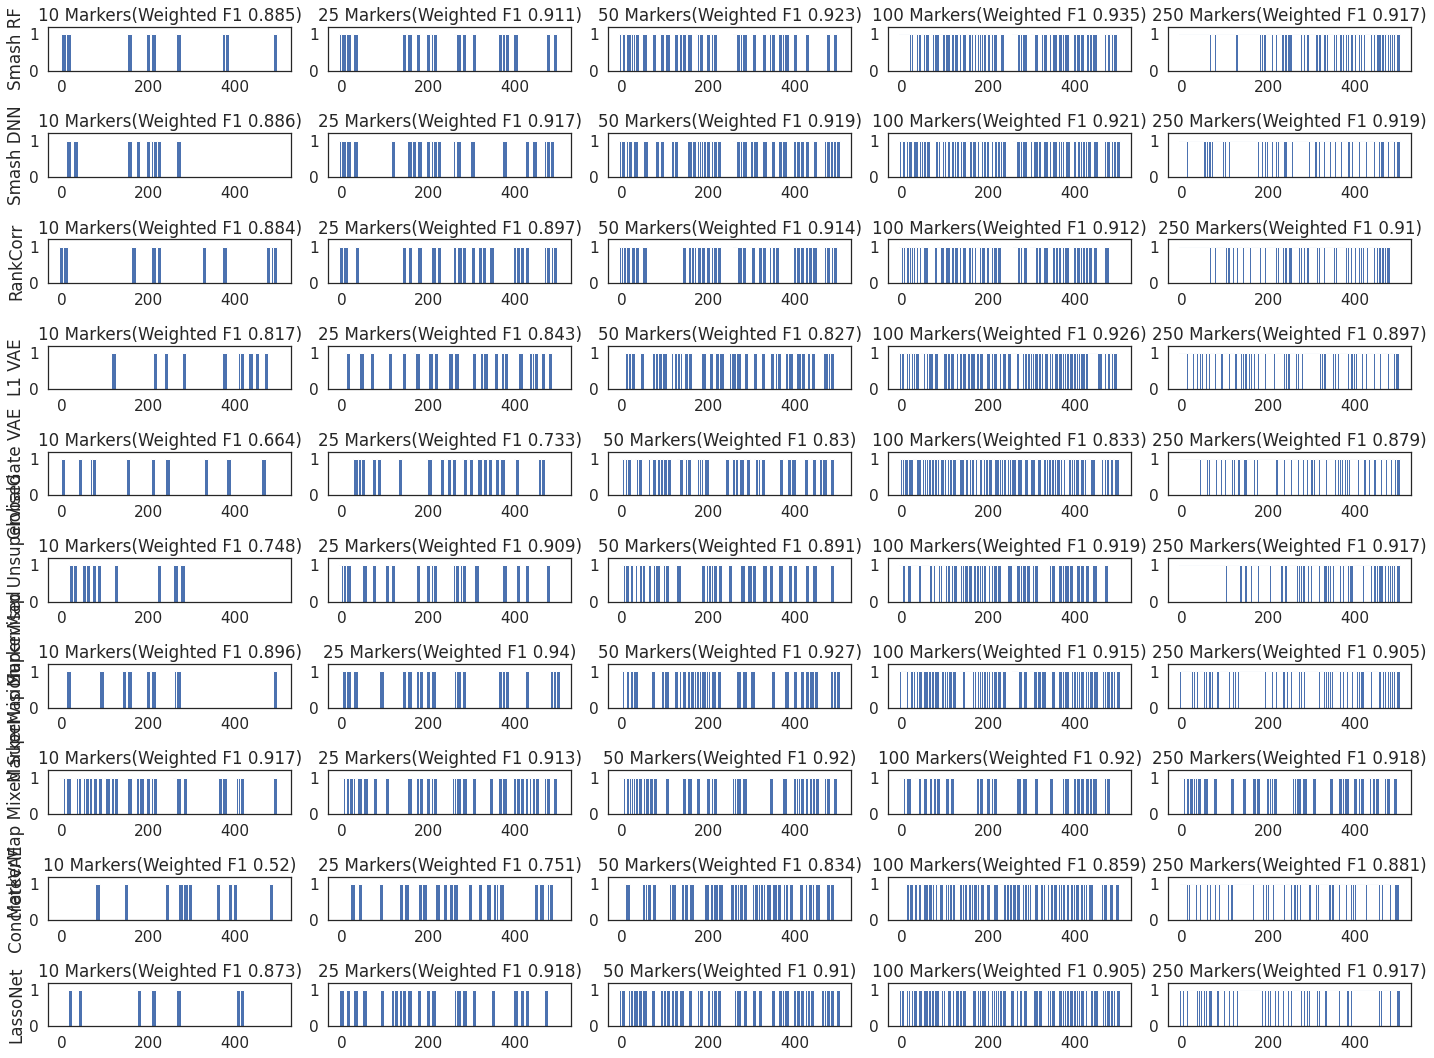

In [86]:
fig, axs = plt.subplots(nrows=10, ncols = len(k_range), figsize = (20, 15))

plot_row(axs[0], 'Smash RF', k_range, smash_rf_markers, smash_rf_f1)
plot_row(axs[1], 'Smash DNN', k_range, smash_dnn_markers, smash_dnn_f1)
plot_row(axs[2], 'RankCorr', k_range, rankcorr_markers, rankcorr_f1)
plot_row(axs[3], 'L1 VAE', k_range, l1_vae_markers, l1_vae_f1)
plot_row(axs[4], 'GlobalGate VAE', k_range, globalgate_vae_markers, globalgate_vae_f1)
plot_row(axs[5], 'MarkerMap Unsupervised', k_range, marker_map_unsupervised_markers, marker_map_unsupervised_f1)
plot_row(axs[6], 'MarkerMap Supervised', k_range, marker_map_supervised_markers, marker_map_supervised_f1)
plot_row(axs[7], 'MarkerMap Mixed Supervision', k_range, marker_map_mixed_markers, marker_map_mixed_f1)
plot_row(axs[8], 'ConcreteVAE', k_range, concrete_vae_markers, concrete_vae_f1)
plot_row(axs[9], 'LassoNet', k_range, lasso_net_markers, lasso_net_f1)


plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_SelectedMarkers_All_Methods_ks.png')
plt.show()

In [87]:
plt.close('all')